In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import googlemaps
import folium
from math import radians, sin, cos, sqrt, atan2
import matplotlib as mpl
import copy
from copy import deepcopy

mpl.rcParams['figure.dpi'] = 300

# Load JSON files again
building_loc_path = "data/building_loc.json"
room_timetable_path = "data/room_timetable.json"
students_info_path = "data/students_info.json"
courses_info_path = "data/courses_info.json"

with open(building_loc_path, "r") as f:
    building_loc = json.load(f)

with open(room_timetable_path, "r") as f:
    room_timetable = json.load(f)

with open(students_info_path, "r") as f:
    students_info = json.load(f)

with open(courses_info_path, "r") as f:
    courses_info = json.load(f)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

# Convert courses data to DataFrame for processing
courses_df = pd.DataFrame(courses_info["courses"])


# Convert time strings to datetime
courses_df["StartTime"] = pd.to_datetime(courses_df["StartTimeStr"], format="%H:%M")
courses_df["EndTime"] = pd.to_datetime(courses_df["EndTimeStr"], format="%H:%M")

# Sort courses by time for sequential analysis
courses_df = courses_df.sort_values(by=["StartTime"])

# Compute travel-related metrics
transitions = []
for i in range(len(courses_df) - 1):
    current_course = courses_df.iloc[i]
    next_course = courses_df.iloc[i + 1]

    # Ensure the gap between courses is less than 20 minutes
    time_gap = (next_course["StartTime"] - current_course["EndTime"]).total_seconds() / 60
    if time_gap < 20:
        # Get building locations
        current_building = str(int(current_course["BuildingNumber"]))
        next_building = str(int(next_course["BuildingNumber"]))

        if current_building in building_loc and next_building in building_loc:
            current_location = building_loc[current_building]
            next_location = building_loc[next_building]

            # Calculate travel distance (haversine formula)
            from math import radians, sin, cos, sqrt, atan2

            def haversine_distance(coord1, coord2):
                R = 6371.0  # Earth radius in km
                lat1, lon1 = radians(coord1[0]), radians(coord1[1])
                lat2, lon2 = radians(coord2[0]), radians(coord2[1])
                dlat, dlon = lat2 - lat1, lon2 - lon1
                a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))
                return R * c  # Distance in km

            travel_distance = haversine_distance(
                (current_location["lat"], current_location["lon"]),
                (next_location["lat"], next_location["lon"])
            )

            # Walking speed in m/s
            walking_speed_mps = 1.4
            travel_time = (travel_distance * 1000) / walking_speed_mps / 60  # Convert to minutes

            # Floor difference
            def extract_floor(room_number):
                return int(room_number[0]) if room_number[0].isdigit() else 1

            floors_traveled = abs(extract_floor(current_course["RoomNumber"]) - extract_floor(next_course["RoomNumber"]))

            # Occupancy rate
            occupancy_rate = current_course["NumStudents"] / current_course["RoomCapacity"] if current_course["RoomCapacity"] > 0 else 0

            transitions.append({
                "course_1": current_course["CourseNumb"],
                "course_2": next_course["CourseNumb"],
                "travel_distance": travel_distance,
                "travel_time": travel_time,
                "floors_traveled": floors_traveled,
                "occupancy_rate": occupancy_rate
            })

# Convert to DataFrame
valid_transitions = pd.DataFrame(transitions)


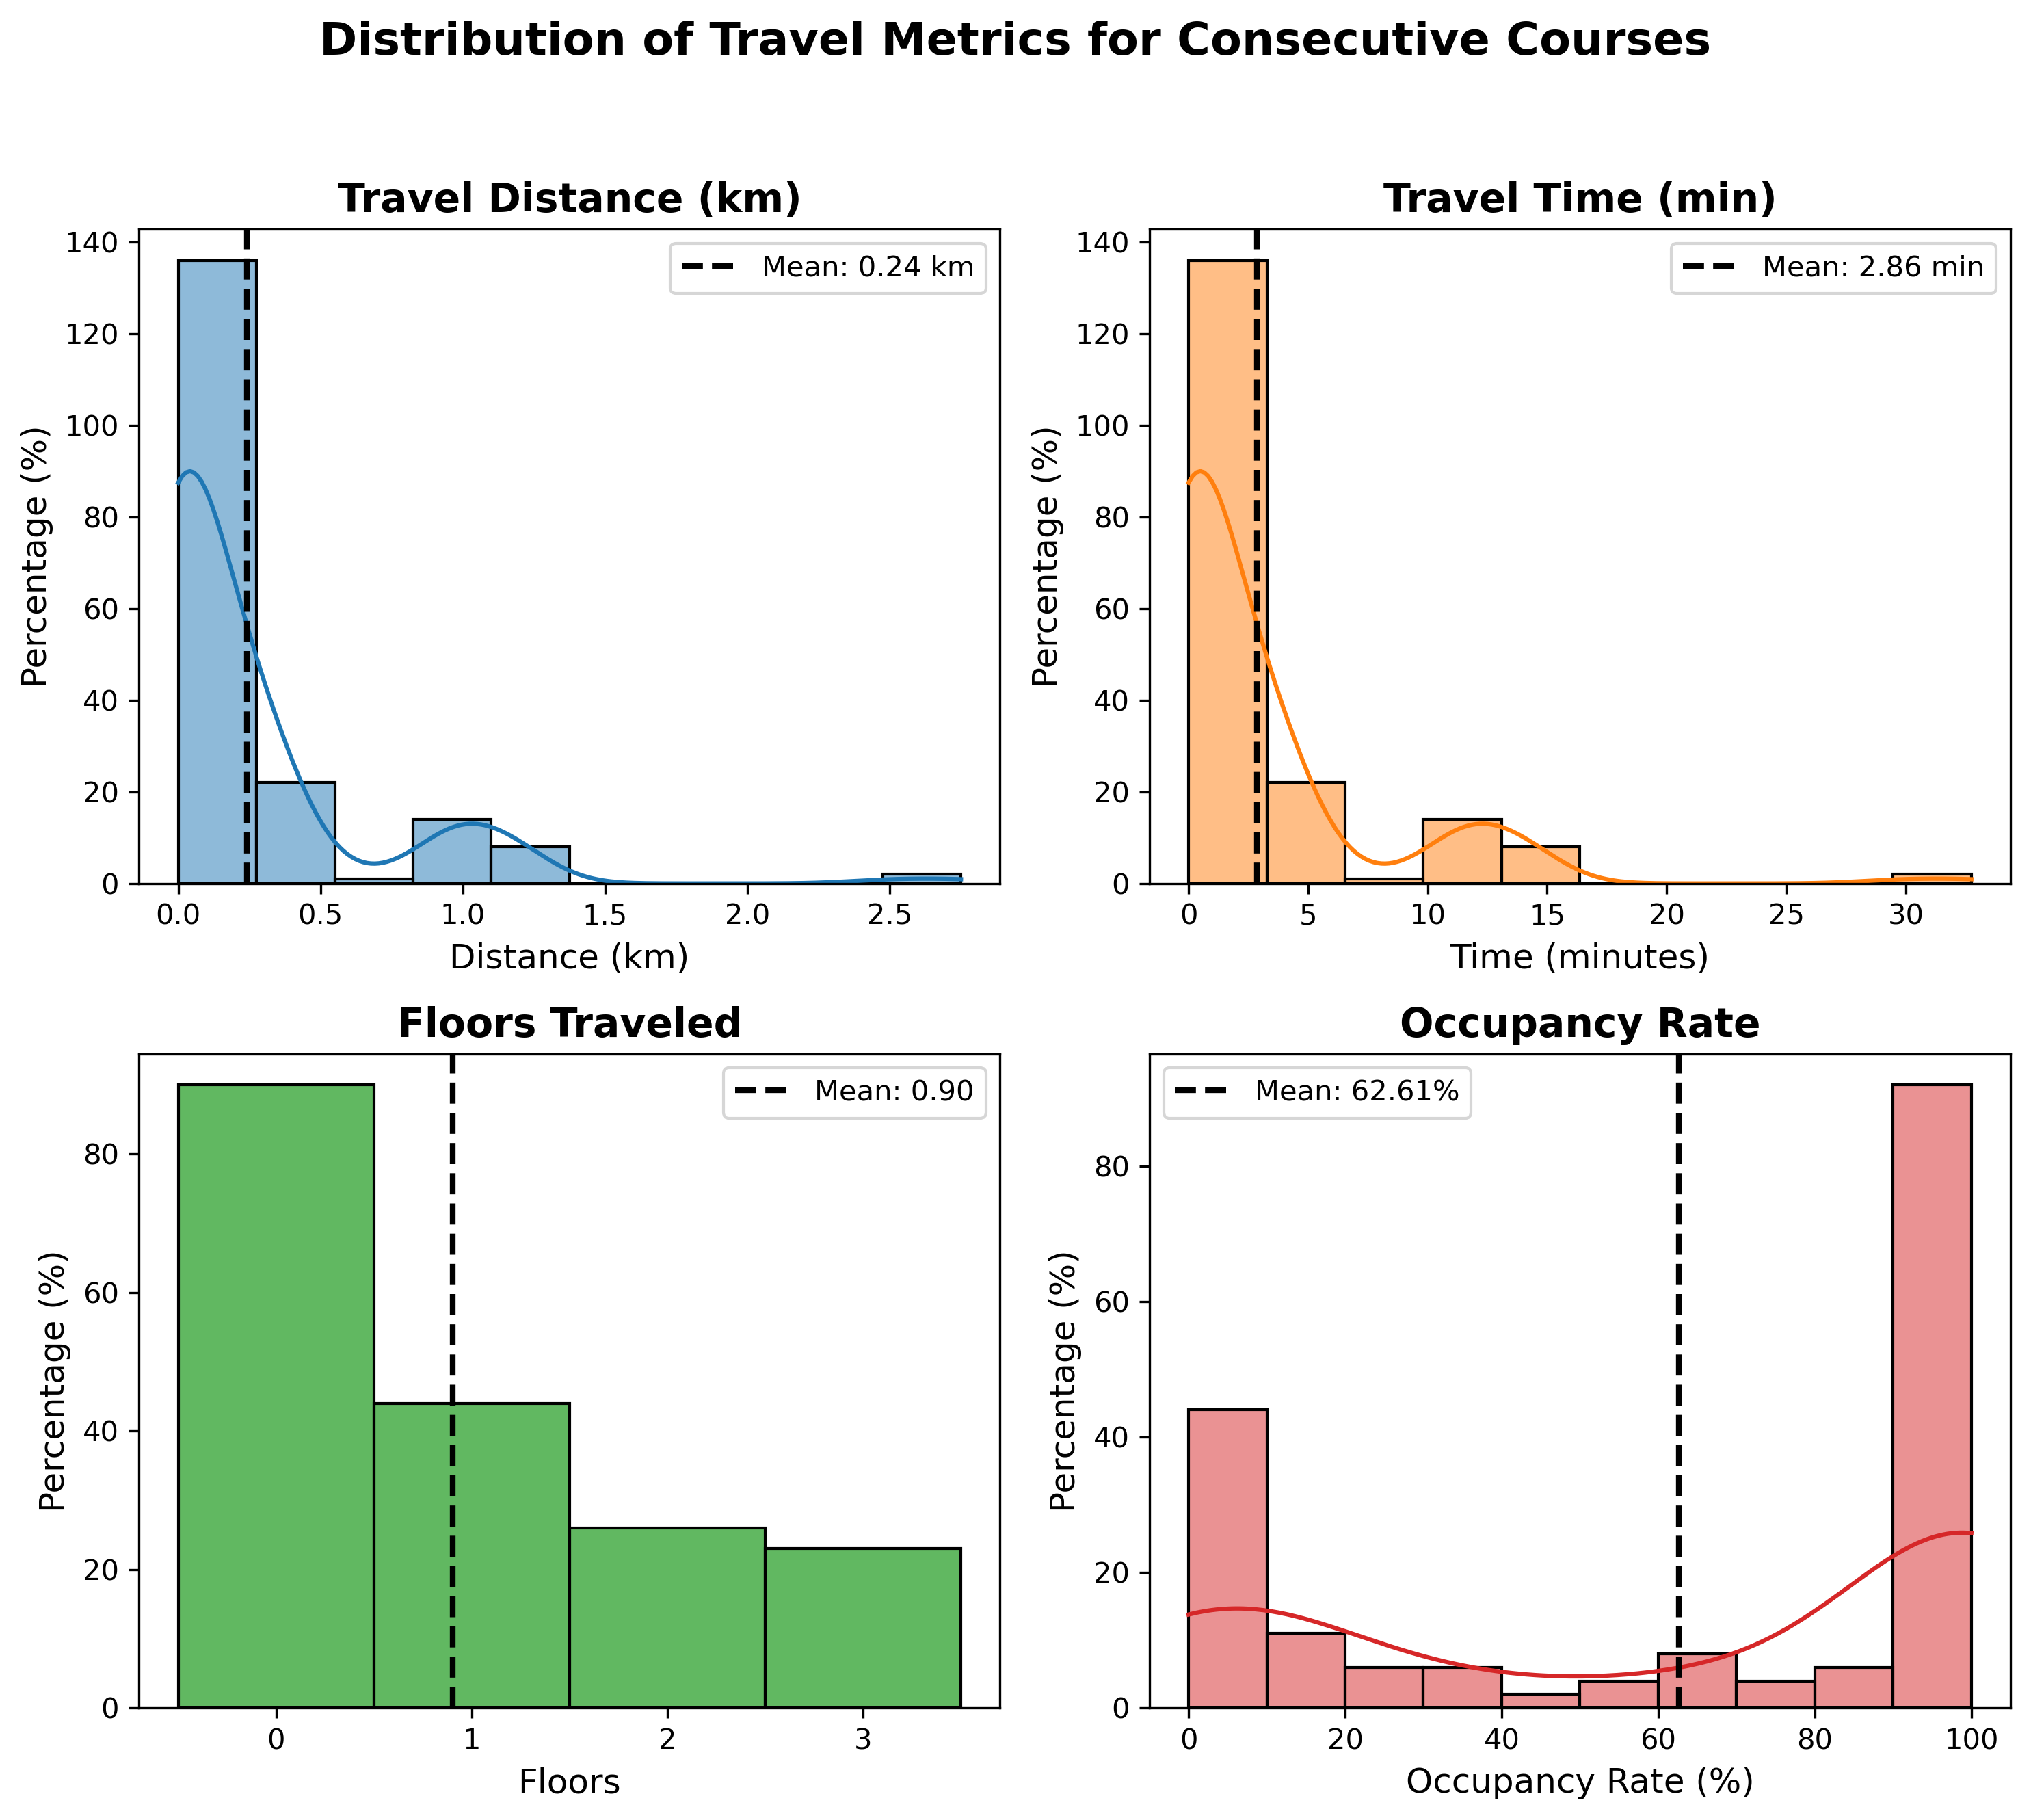

In [3]:
# Enhanced Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
fig.suptitle("Distribution of Travel Metrics for Consecutive Courses", fontsize=16, fontweight="bold")

# Define colors
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Travel Distance Distribution
sns.histplot(valid_transitions["travel_distance"], bins=10, kde=True, ax=axes[0, 0], color=colors[0])
mean_distance = valid_transitions["travel_distance"].mean()
axes[0, 0].axvline(mean_distance, color="black", linestyle="dashed", linewidth=2, label=f"Mean: {mean_distance:.2f} km")
axes[0, 0].set_title("Travel Distance (km)", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Distance (km)", fontsize=12)
axes[0, 0].set_ylabel("Percentage (%)", fontsize=12)
axes[0, 0].legend()

# Travel Time Distribution
sns.histplot(valid_transitions["travel_time"], bins=10, kde=True, ax=axes[0, 1], color=colors[1])
mean_time = valid_transitions["travel_time"].mean()
axes[0, 1].axvline(mean_time, color="black", linestyle="dashed", linewidth=2, label=f"Mean: {mean_time:.2f} min")
axes[0, 1].set_title("Travel Time (min)", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Time (minutes)", fontsize=12)
axes[0, 1].set_ylabel("Percentage (%)", fontsize=12)
axes[0, 1].legend()

# Floors Traveled Distribution
sns.histplot(valid_transitions["floors_traveled"], bins=range(int(valid_transitions["floors_traveled"].min()), 
                                                               int(valid_transitions["floors_traveled"].max()) + 2), 
             kde=False, ax=axes[1, 0], color=colors[2], discrete=True)
mean_floors = valid_transitions["floors_traveled"].mean()
axes[1, 0].axvline(mean_floors, color="black", linestyle="dashed", linewidth=2, label=f"Mean: {mean_floors:.2f}")
axes[1, 0].set_xticks(range(int(valid_transitions["floors_traveled"].min()), 
                            int(valid_transitions["floors_traveled"].max()) + 1))
axes[1, 0].set_title("Floors Traveled", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Floors", fontsize=12)
axes[1, 0].set_ylabel("Percentage (%)", fontsize=12)
axes[1, 0].legend()

# Occupancy Rate Distribution
sns.histplot(valid_transitions["occupancy_rate"] * 100, bins=10, kde=True, ax=axes[1, 1], color=colors[3])
mean_occupancy = valid_transitions["occupancy_rate"].mean() * 100
axes[1, 1].axvline(mean_occupancy, color="black", linestyle="dashed", linewidth=2, label=f"Mean: {mean_occupancy:.2f}%")
axes[1, 1].set_title("Occupancy Rate", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Occupancy Rate (%)", fontsize=12)
axes[1, 1].set_ylabel("Percentage (%)", fontsize=12)
axes[1, 1].legend()

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

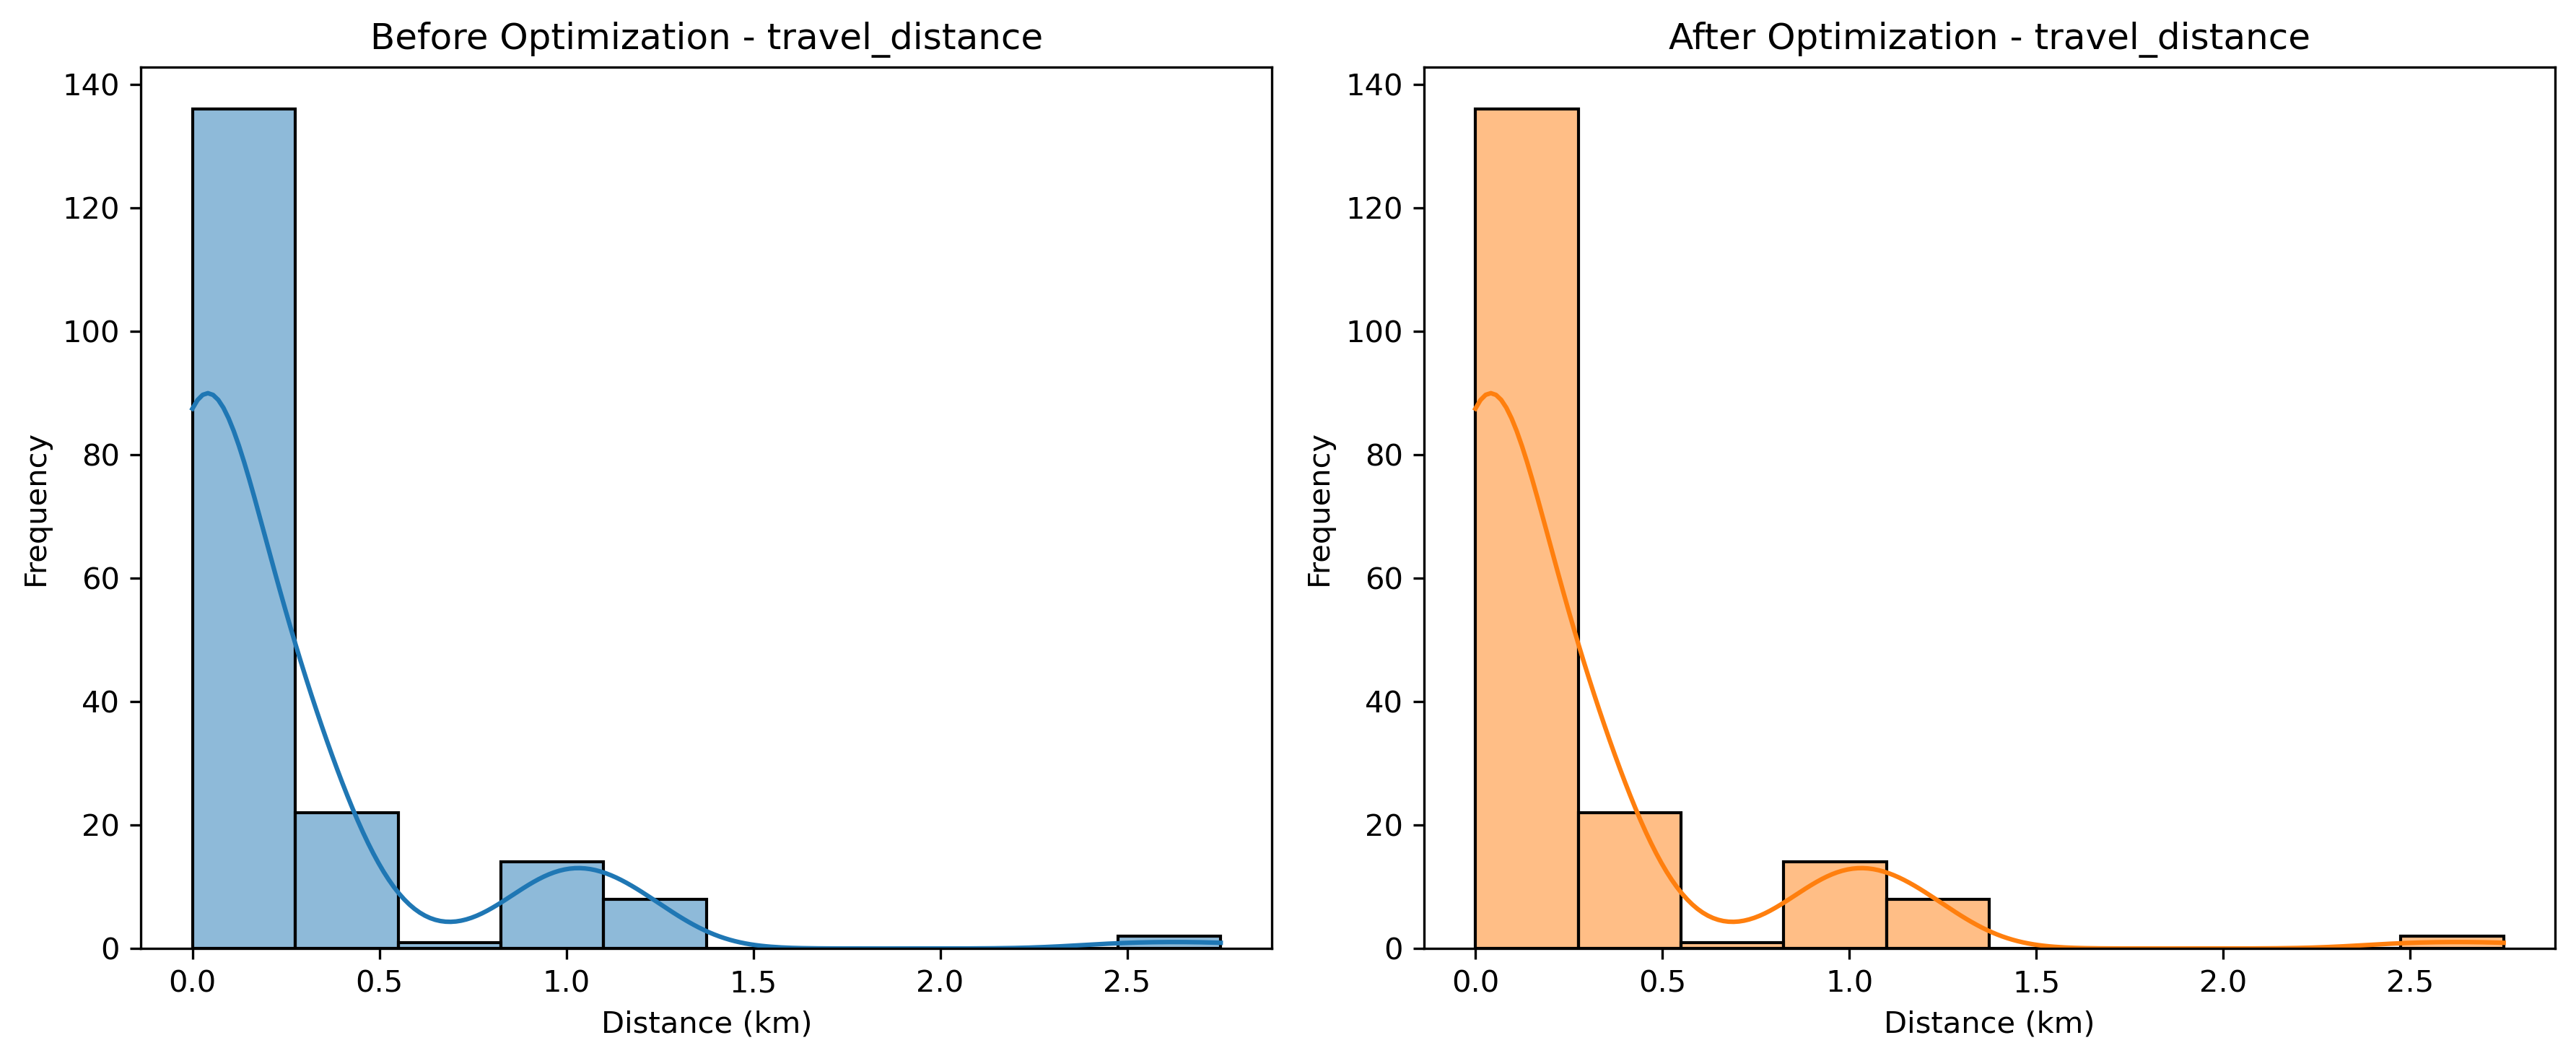

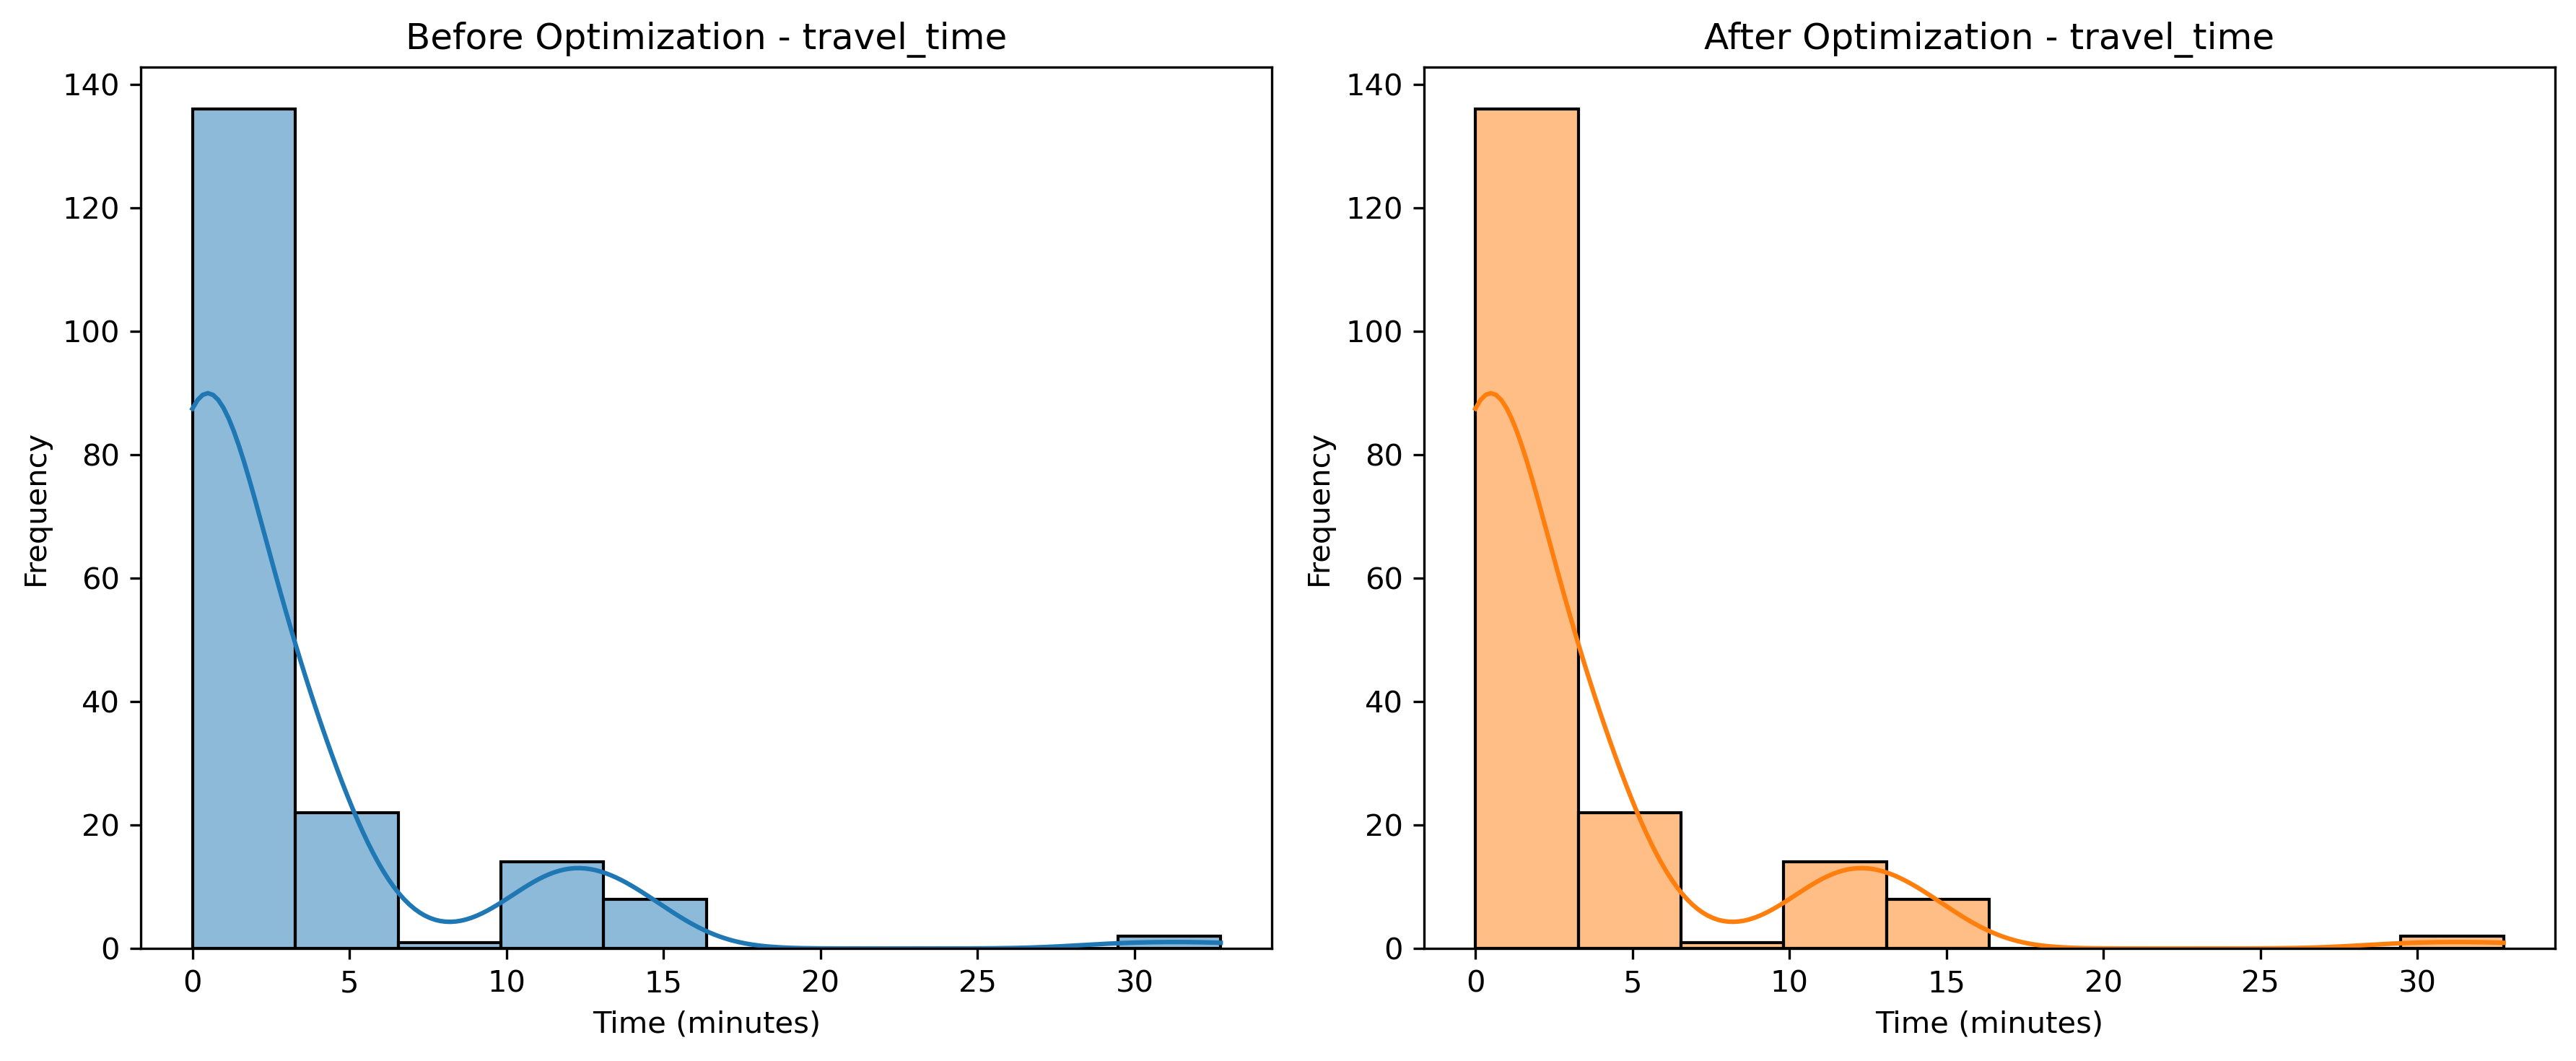

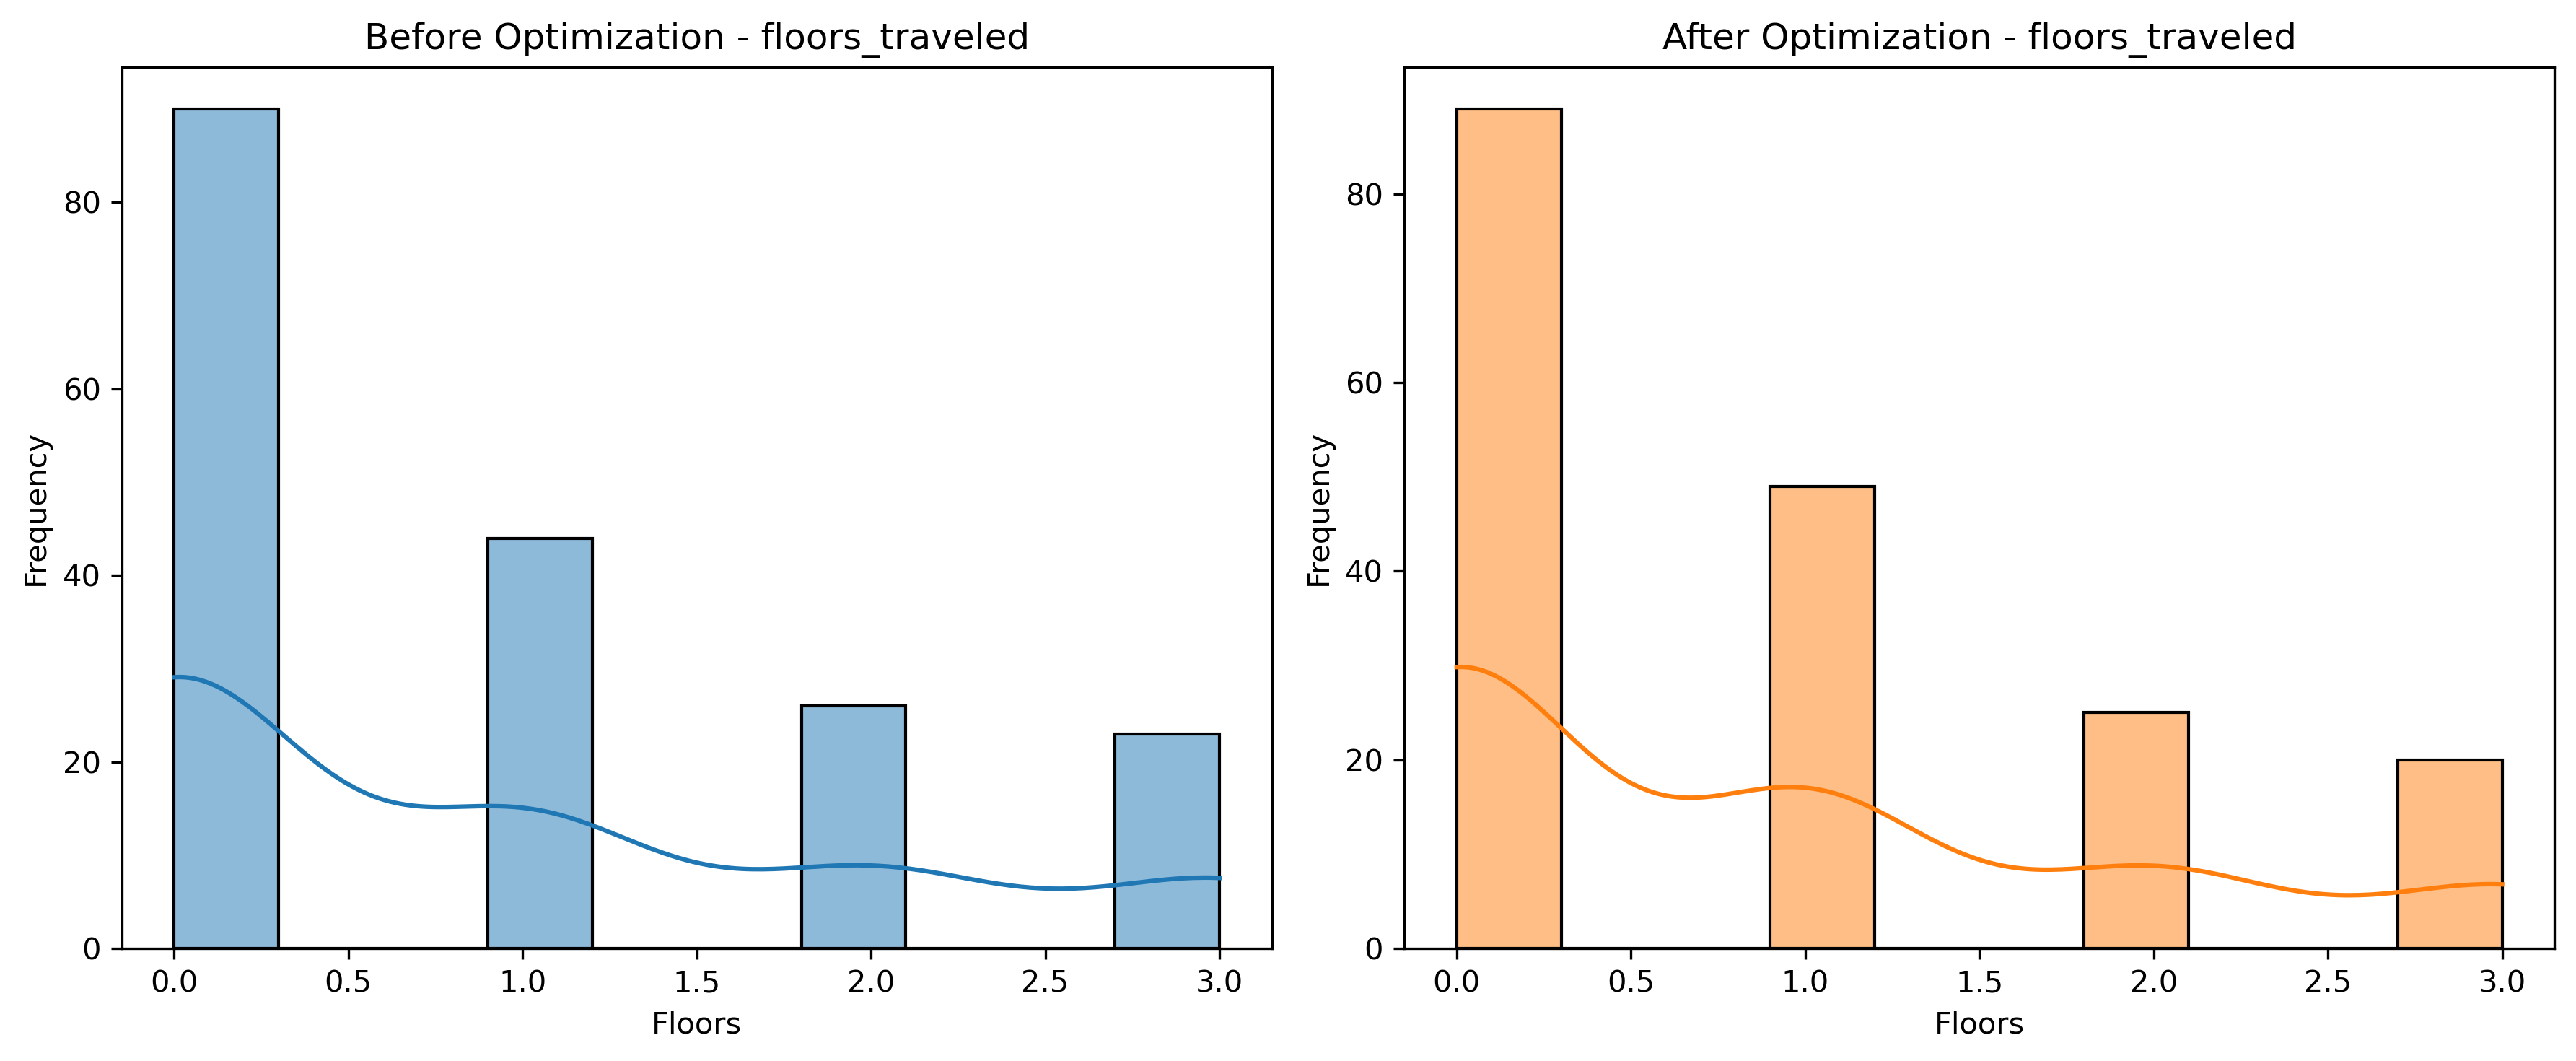

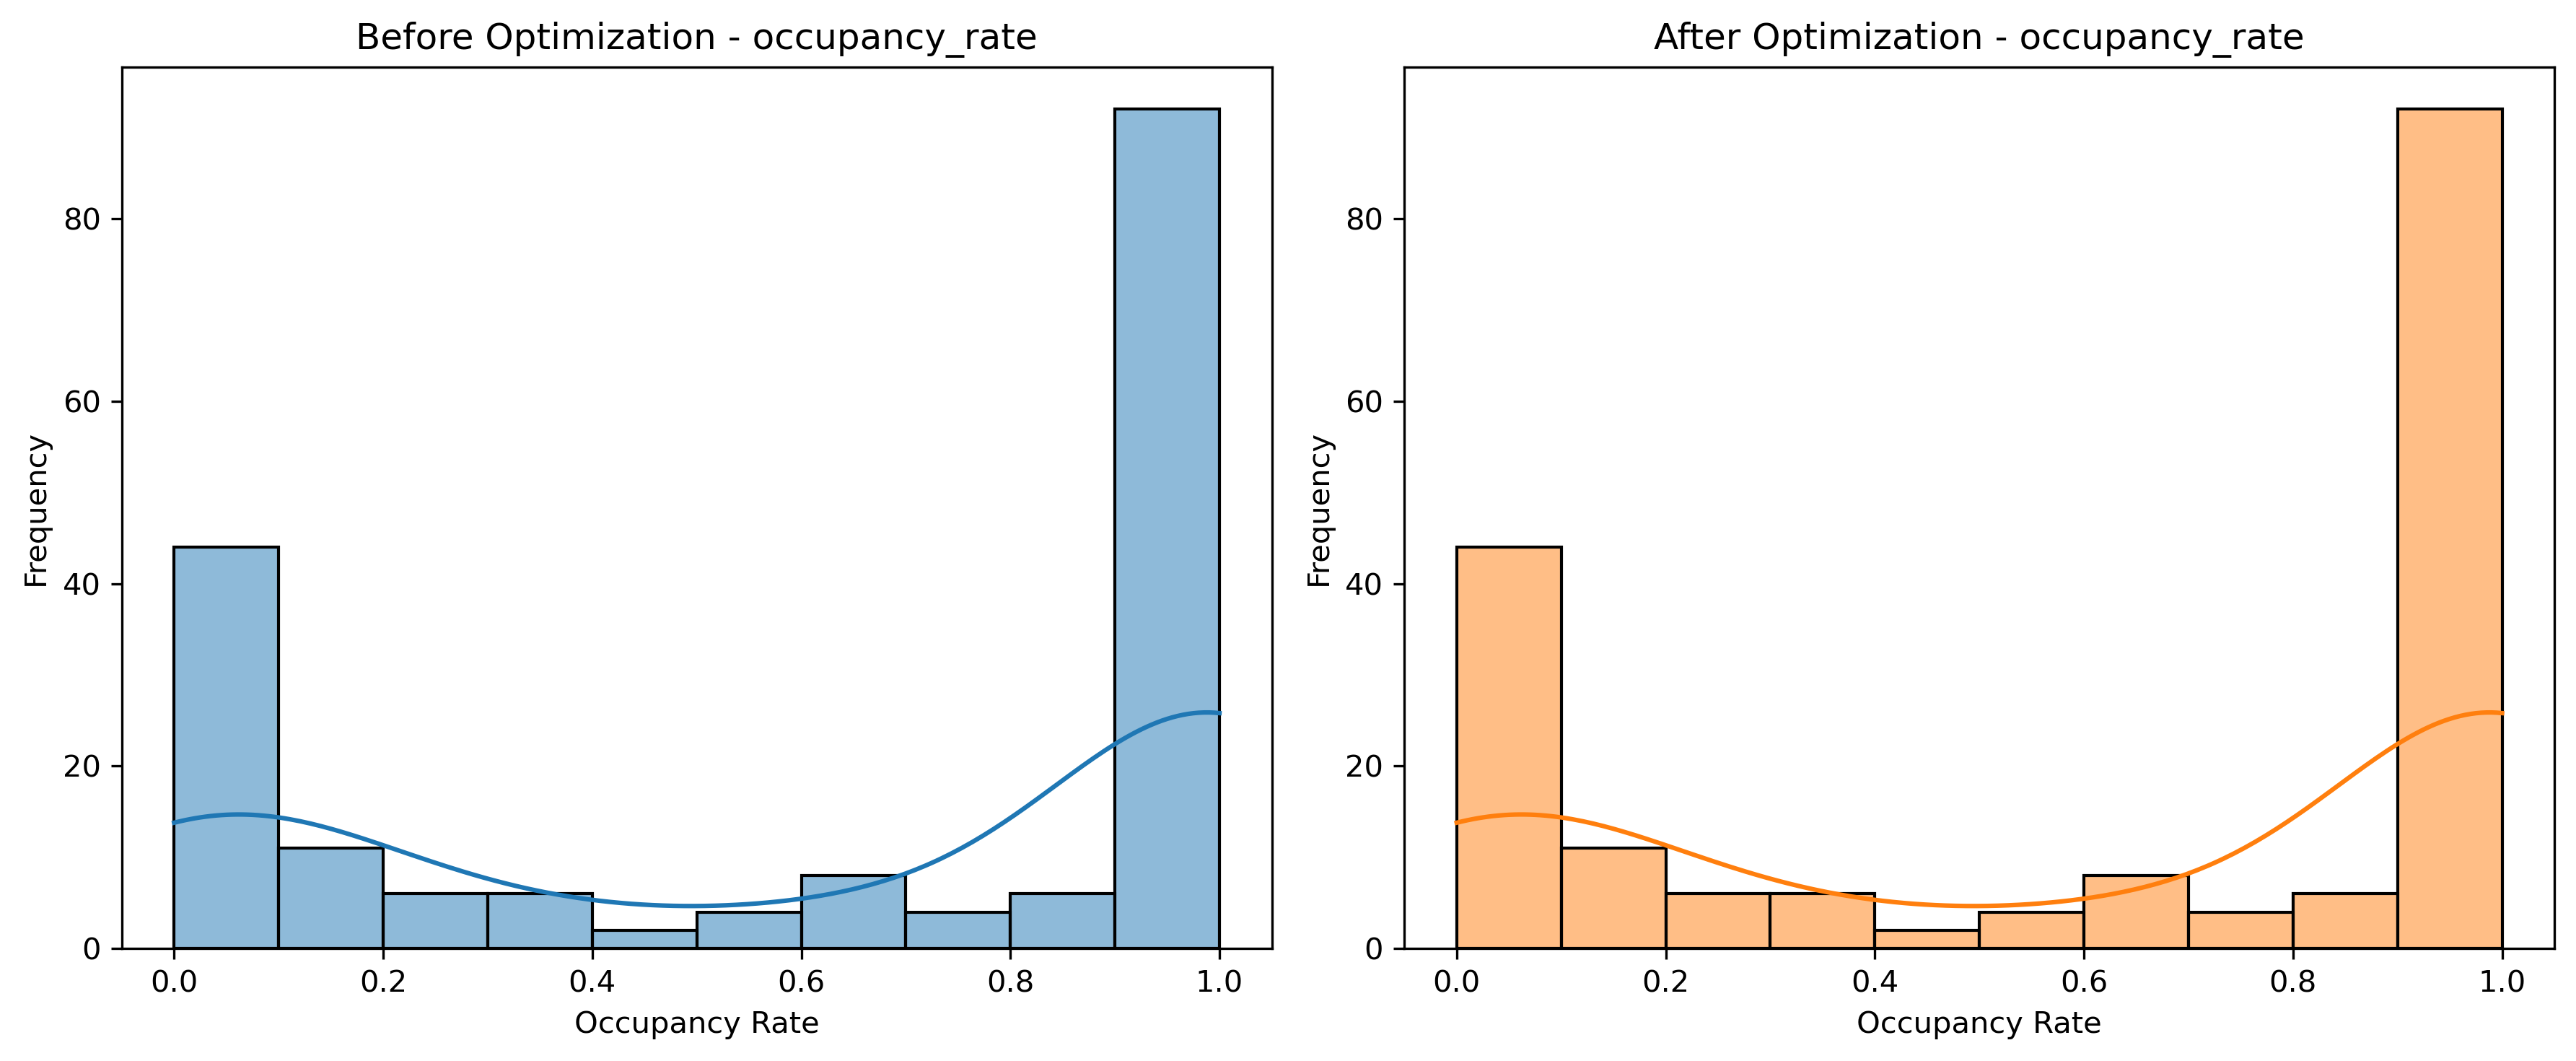

In [4]:
# Haversine formula for distance calculation
def haversine_distance(coord1, coord2):
    R = 6371.0  # Earth radius in km
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in km

# Extract floor number from room number
def extract_floor(room_number):
    return int(room_number[0]) if room_number[0].isdigit() else 1

# Compute travel-related metrics
def compute_transitions(courses_df):
    transitions = []
    for i in range(len(courses_df) - 1):
        current_course = courses_df.iloc[i]
        next_course = courses_df.iloc[i + 1]

        # Ensure the gap between courses is less than 20 minutes
        time_gap = (next_course["StartTime"] - current_course["EndTime"]).total_seconds() / 60
        if time_gap < 20:
            current_building = str(int(current_course["BuildingNumber"]))
            next_building = str(int(next_course["BuildingNumber"]))

            if current_building in building_loc and next_building in building_loc:
                current_location = building_loc[current_building]
                next_location = building_loc[next_building]

                # Travel Distance & Time
                travel_distance = haversine_distance(
                    (current_location["lat"], current_location["lon"]),
                    (next_location["lat"], next_location["lon"])
                )
                walking_speed_mps = 1.4
                travel_time = (travel_distance * 1000) / walking_speed_mps / 60  # Convert to minutes

                # Floor difference
                floors_traveled = abs(extract_floor(current_course["RoomNumber"]) - extract_floor(next_course["RoomNumber"]))

                # Occupancy Rate
                occupancy_rate = current_course["NumStudents"] / current_course["RoomCapacity"] if current_course["RoomCapacity"] > 0 else 0

                transitions.append({
                    "course_1": current_course["CourseNumb"],
                    "course_2": next_course["CourseNumb"],
                    "travel_distance": travel_distance,
                    "travel_time": travel_time,
                    "floors_traveled": floors_traveled,
                    "occupancy_rate": occupancy_rate,
                    "num_students": current_course["NumStudents"]
                })
    return pd.DataFrame(transitions)

# Find the bottleneck transition (highest impact on student movement)
def find_bottleneck(transition_df, metric="travel_distance"):
    transition_df["bottleneck_score"] = transition_df[metric] * transition_df["num_students"]
    return transition_df.loc[transition_df["bottleneck_score"].idxmax()]

# Find alternative classrooms that improve metrics
def find_alternative_classroom(current_course, next_course):
    available_rooms = []

    for building, rooms in room_timetable.items():
        for room, schedules in rooms.items():
            # Check if the room is available
            is_available = all(
                not (schedule["StartTime"] < next_course["EndTimeStr"] and schedule["EndTime"] > next_course["StartTimeStr"])
                for schedule in schedules
            )
            if is_available:
                building_id = [k for k, v in building_loc.items() if v["name"] == building][0]
                building_data = building_loc.get(building_id)

                # Compute travel distance & time
                travel_distance = haversine_distance(
                    (building_loc[str(int(current_course["BuildingNumber"]))]["lat"],
                     building_loc[str(int(current_course["BuildingNumber"]))]["lon"]),
                    (building_data["lat"], building_data["lon"])
                )
                travel_time = (travel_distance * 1000) / 1.4 / 60

                # Floor difference
                new_floor = extract_floor(room)
                floors_traveled = abs(extract_floor(current_course["RoomNumber"]) - new_floor)

                # Store available room
                available_rooms.append({
                    "room": room,
                    "building": building,
                    "building_id": building_id,
                    "travel_distance": travel_distance,
                    "travel_time": travel_time,
                    "floors_traveled": floors_traveled
                })

    if available_rooms:
        return min(available_rooms, key=lambda x: (x["travel_distance"], x["travel_time"], x["floors_traveled"]))
    return None

# Iterative Optimization Process
def iterative_optimization(courses_df, iterations=3):
    for _ in range(iterations):
        transitions_df = compute_transitions(courses_df)
        bottleneck = find_bottleneck(transitions_df)

        # Find alternative
        current_course = courses_df[courses_df["CourseNumb"] == bottleneck["course_1"]].iloc[0]
        next_course = courses_df[courses_df["CourseNumb"] == bottleneck["course_2"]].iloc[0]
        alternative = find_alternative_classroom(current_course, next_course)

        if alternative:
            courses_df.loc[courses_df["CourseNumb"] == bottleneck["course_2"], "BuildingName"] = alternative["building"]
            courses_df.loc[courses_df["CourseNumb"] == bottleneck["course_2"], "RoomNumber"] = alternative["room"]
    return courses_df

# Visualization
def plot_metrics(before, after, metric, xlabel):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = ["#1f77b4", "#ff7f0e"]

    sns.histplot(before, bins=10, kde=True, ax=axes[0], color=colors[0])
    axes[0].set_title(f"Before Optimization - {metric}")
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel("Frequency")

    sns.histplot(after, bins=10, kde=True, ax=axes[1], color=colors[1])
    axes[1].set_title(f"After Optimization - {metric}")
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Run Optimization
before_optimization = compute_transitions(courses_df)
optimized_courses = iterative_optimization(courses_df, iterations=100)
after_optimization = compute_transitions(optimized_courses)

# Plot results
for metric, xlabel in zip(["travel_distance", "travel_time", "floors_traveled", "occupancy_rate"],
                           ["Distance (km)", "Time (minutes)", "Floors", "Occupancy Rate"]):
    plot_metrics(before_optimization[metric], after_optimization[metric], metric, xlabel)


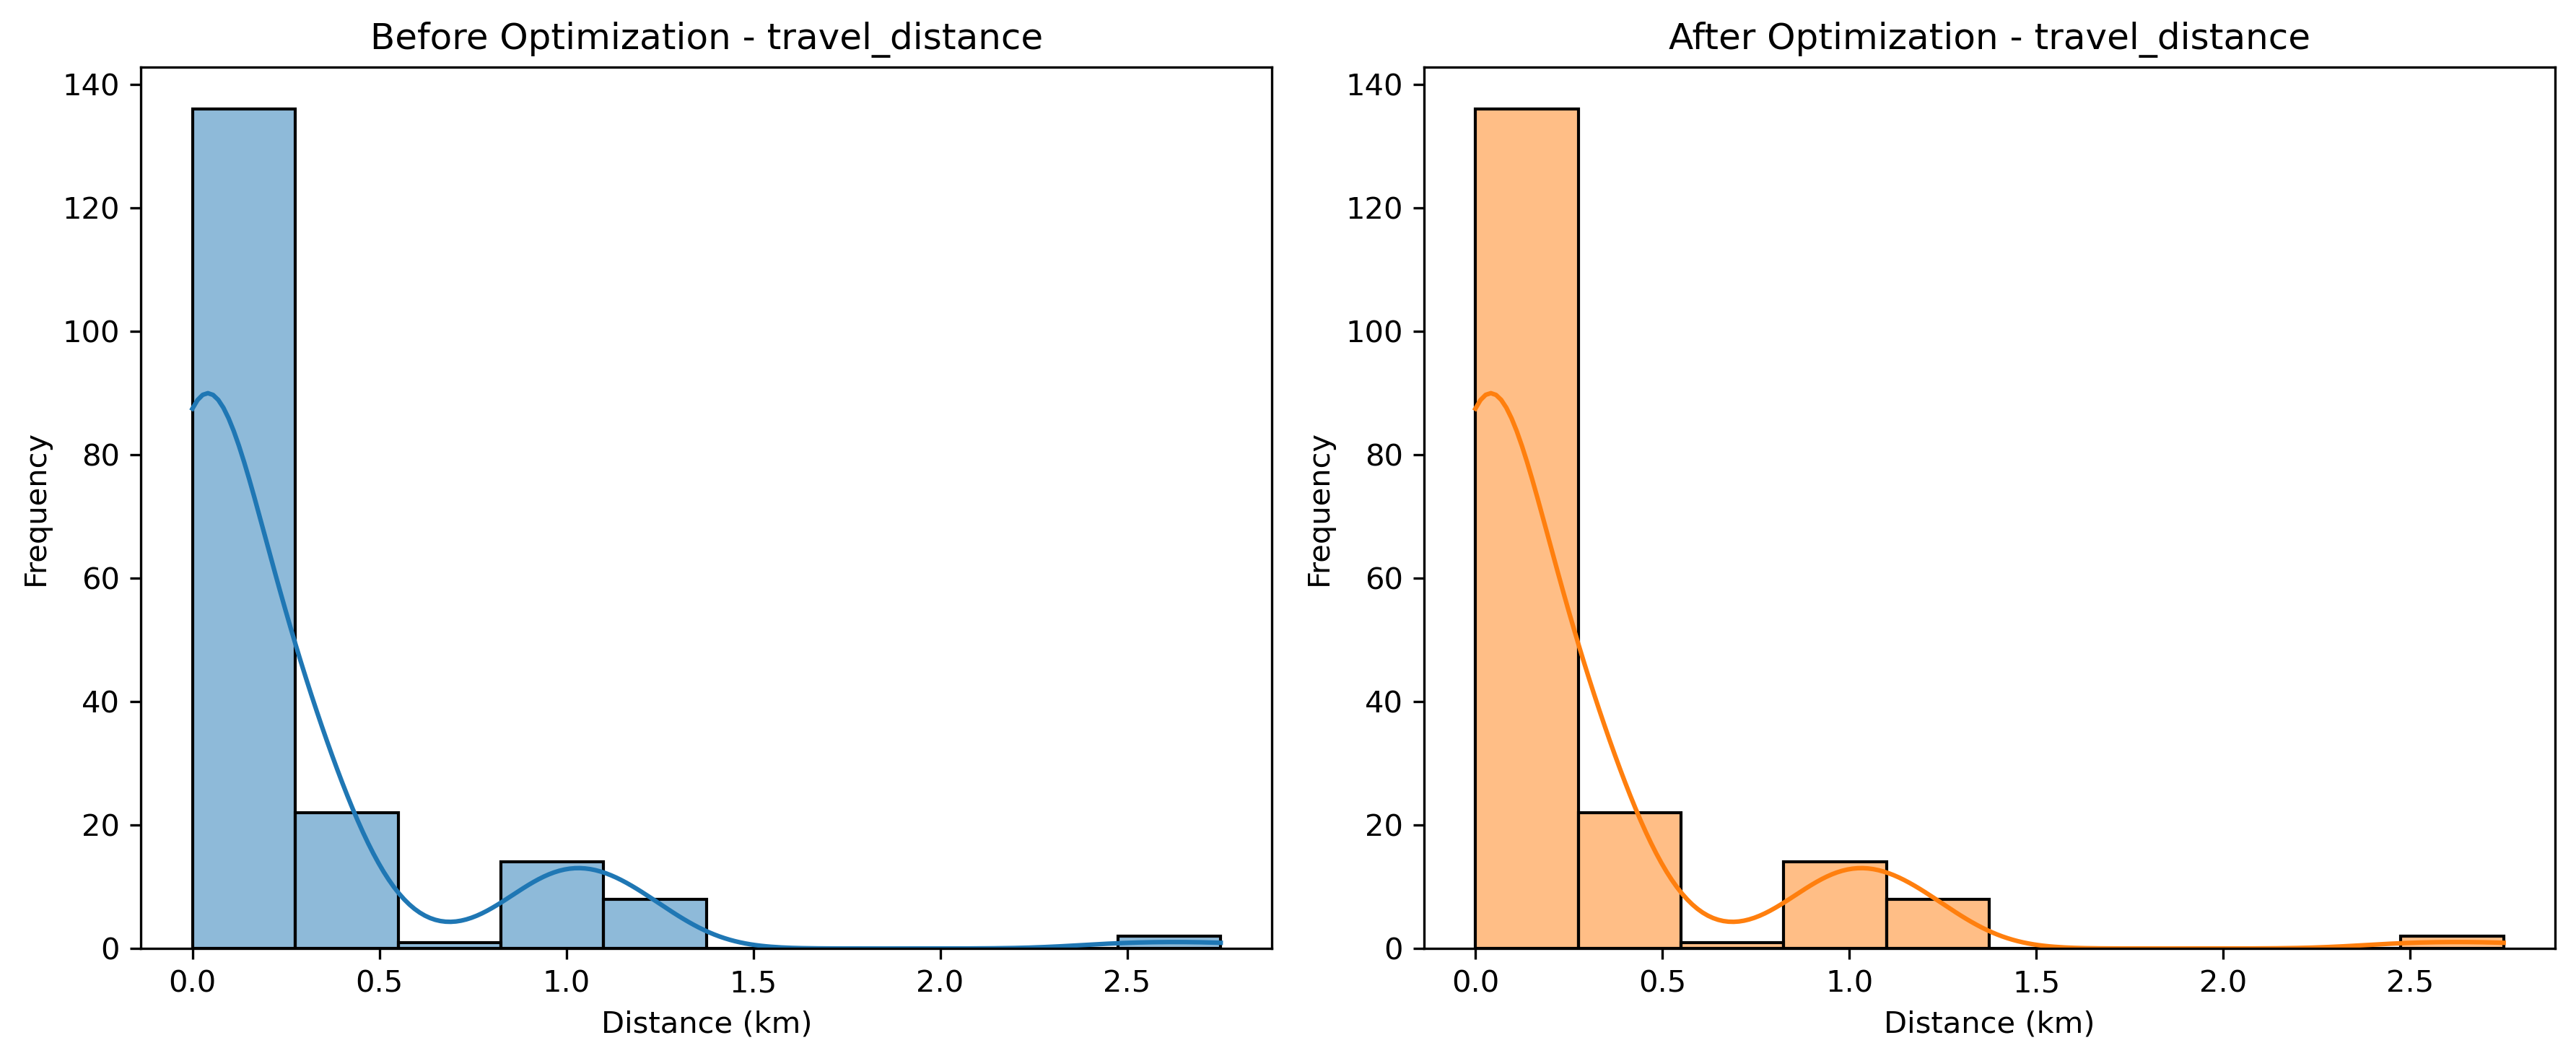

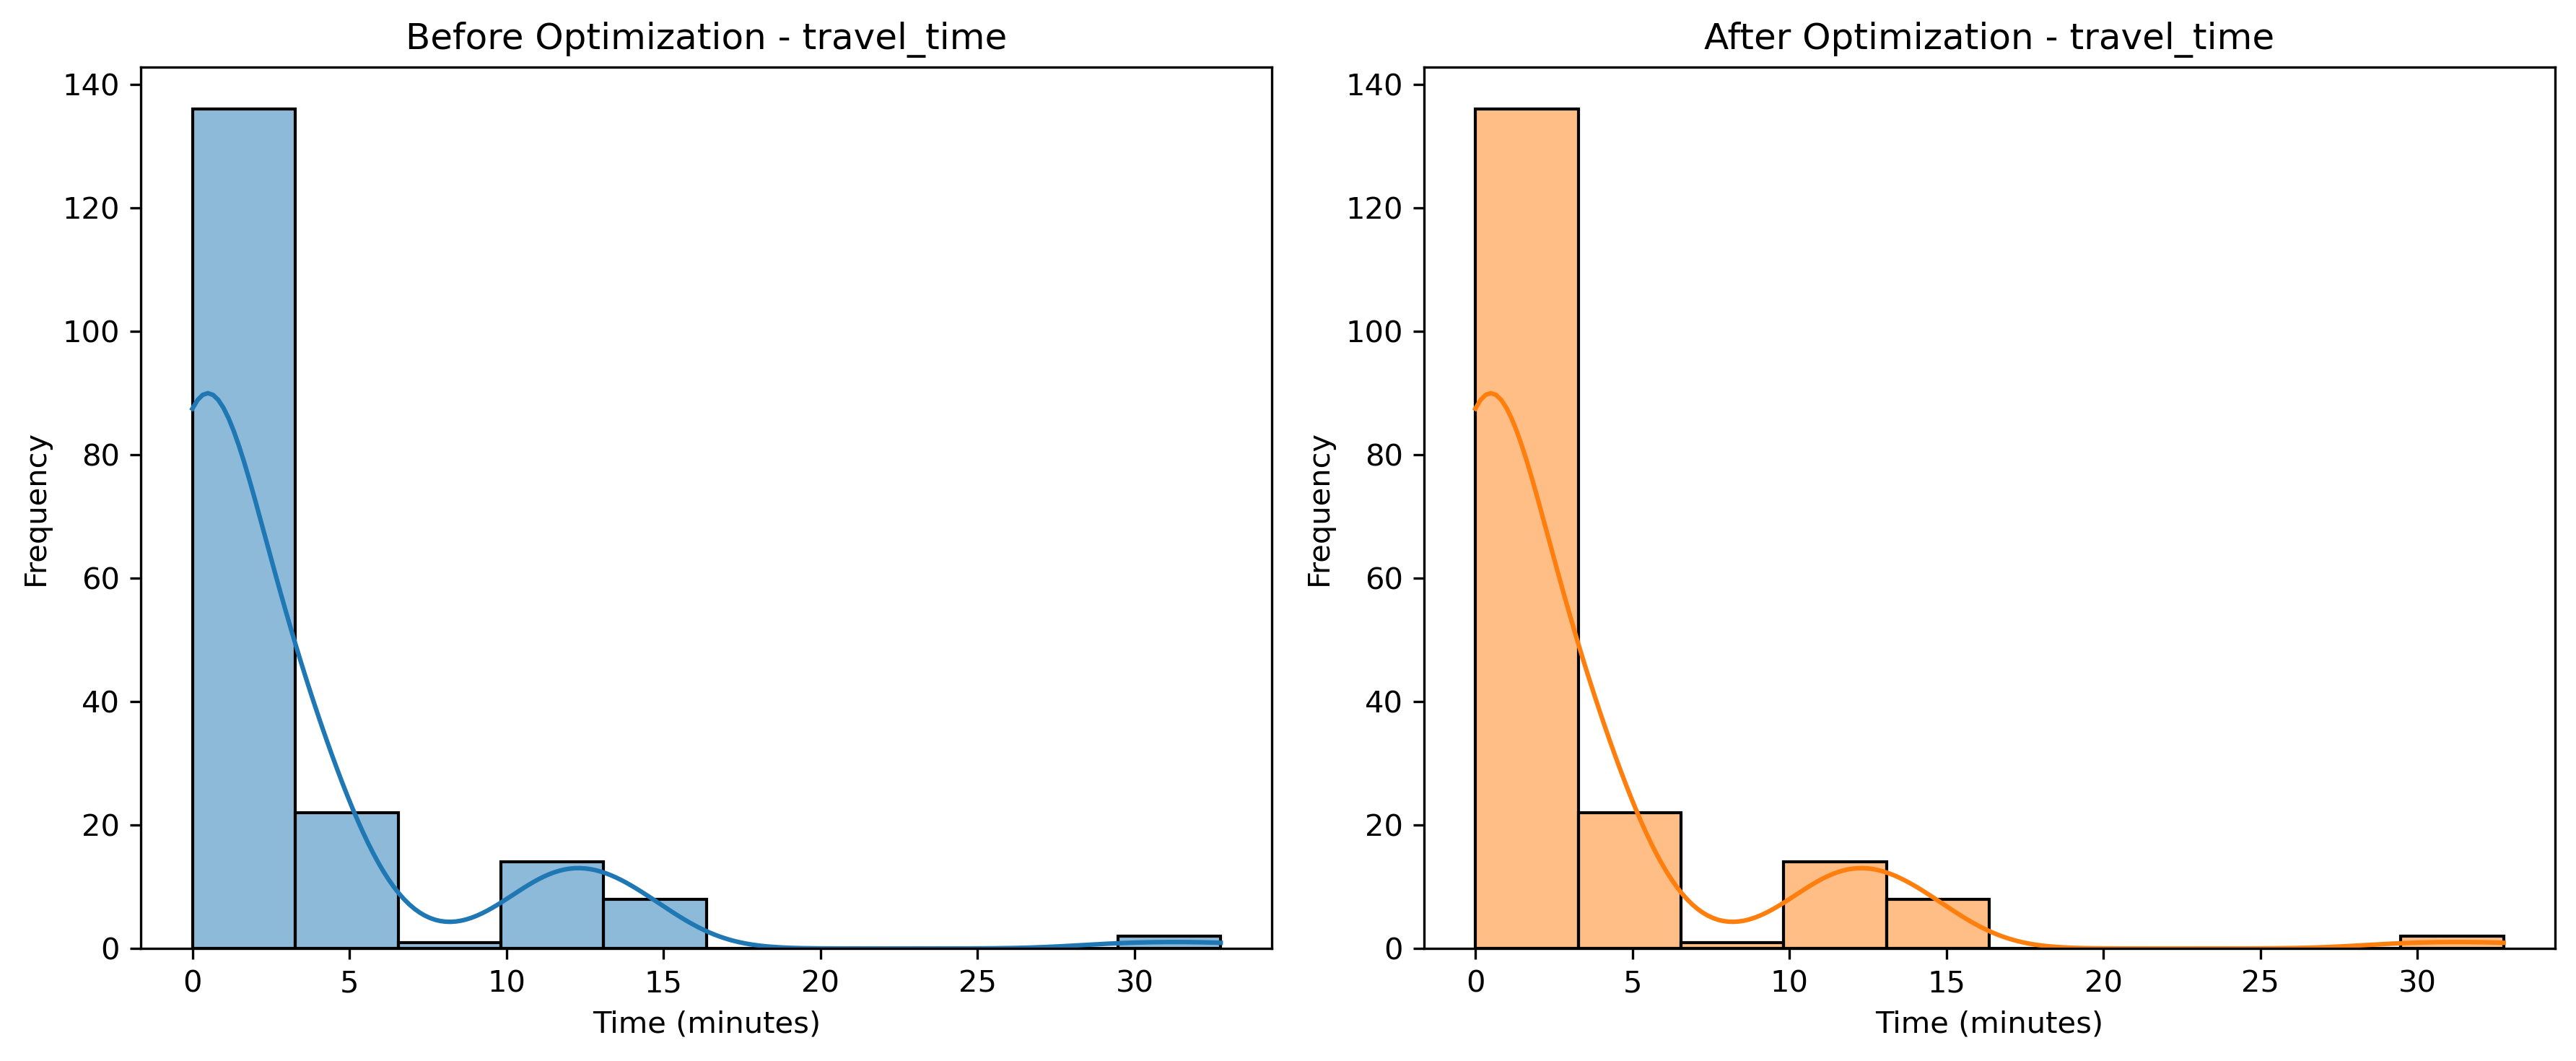

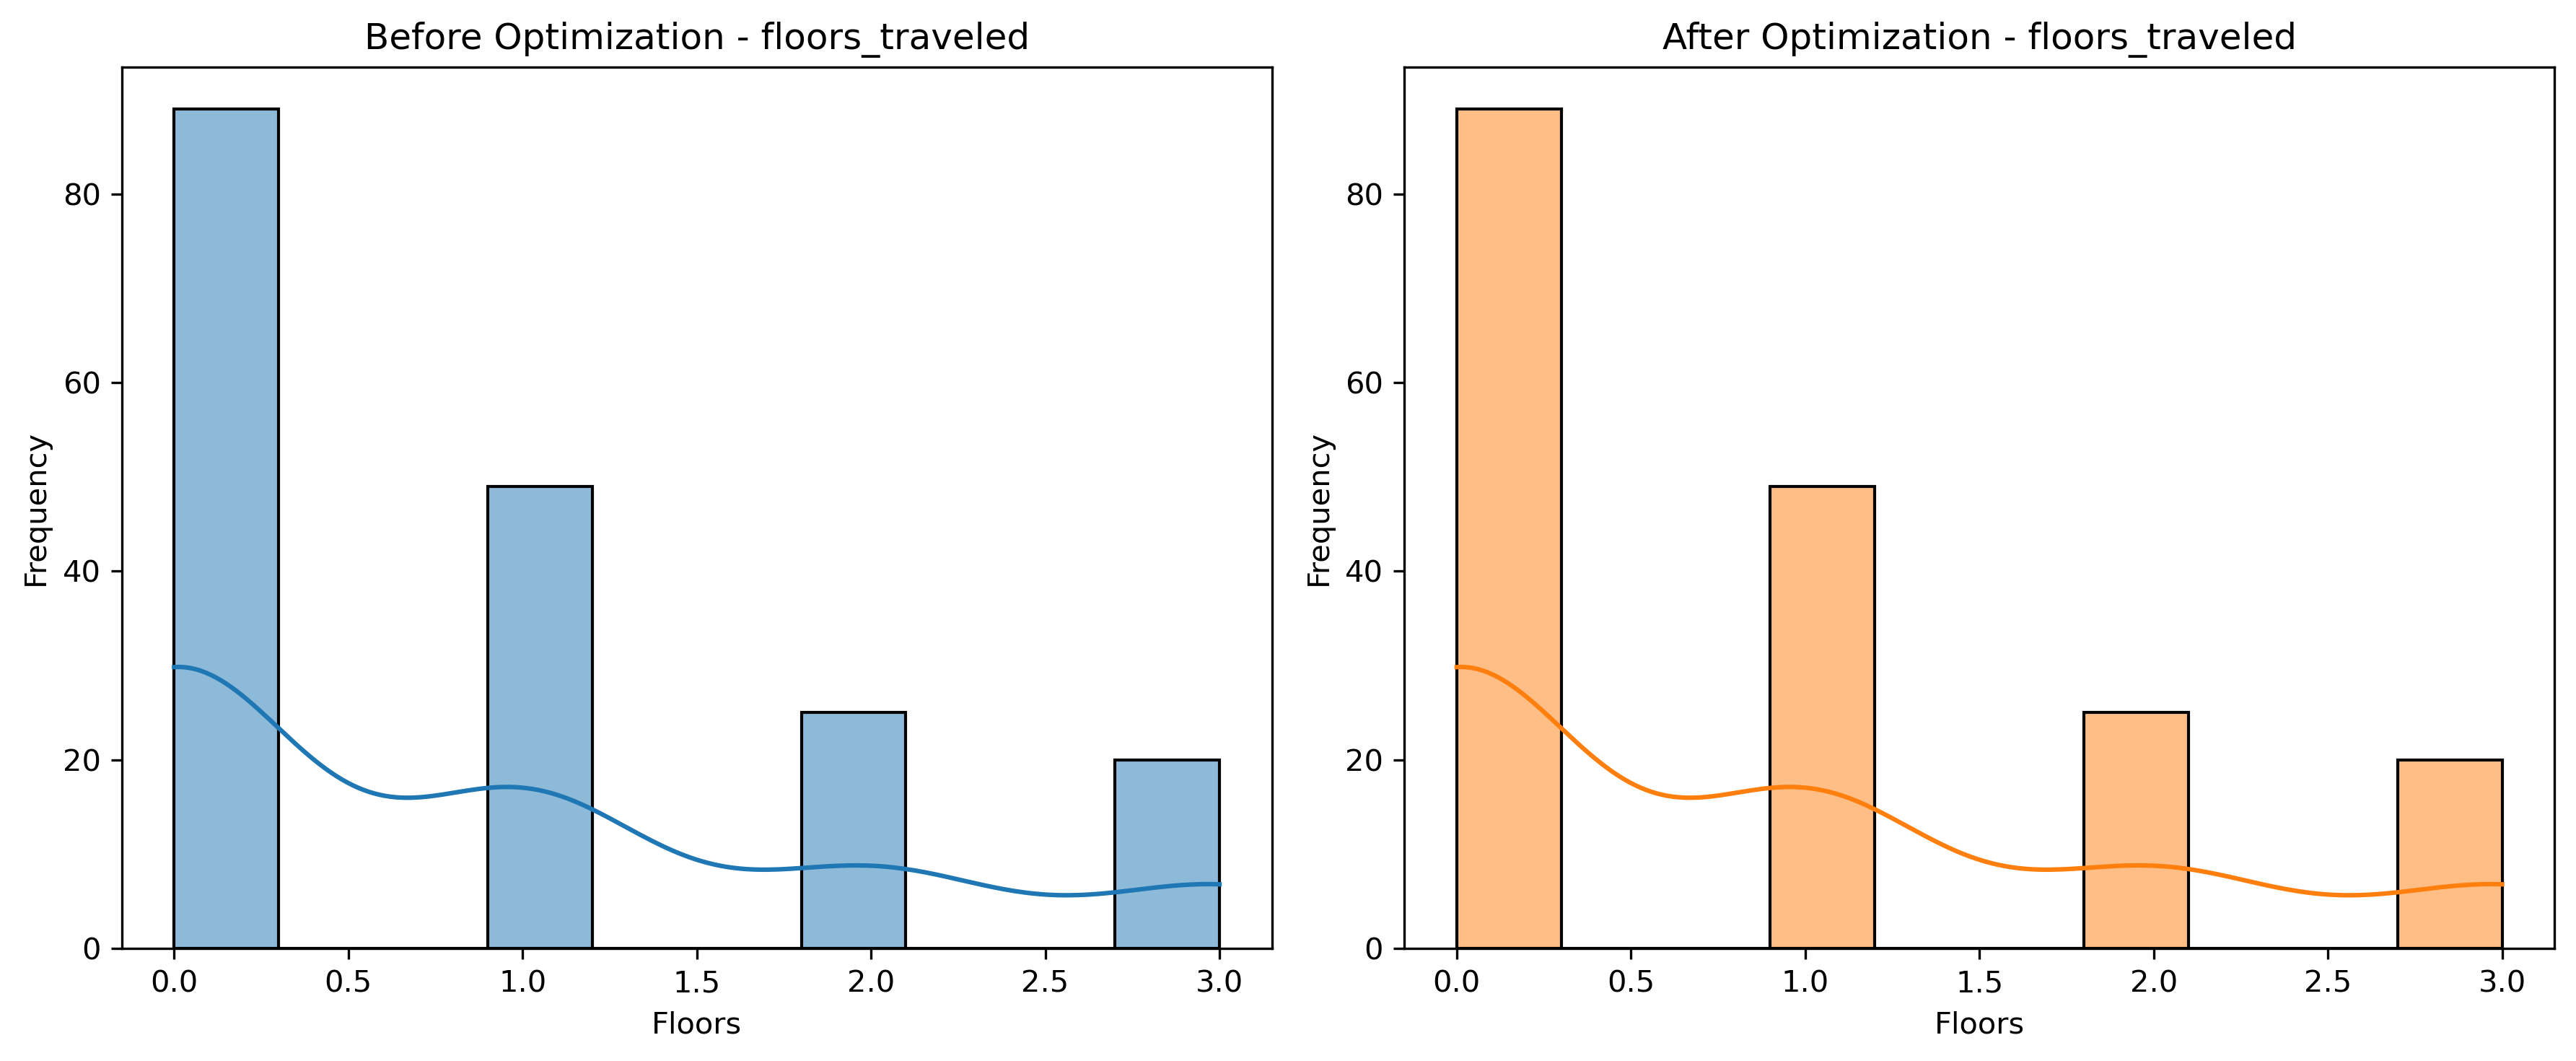

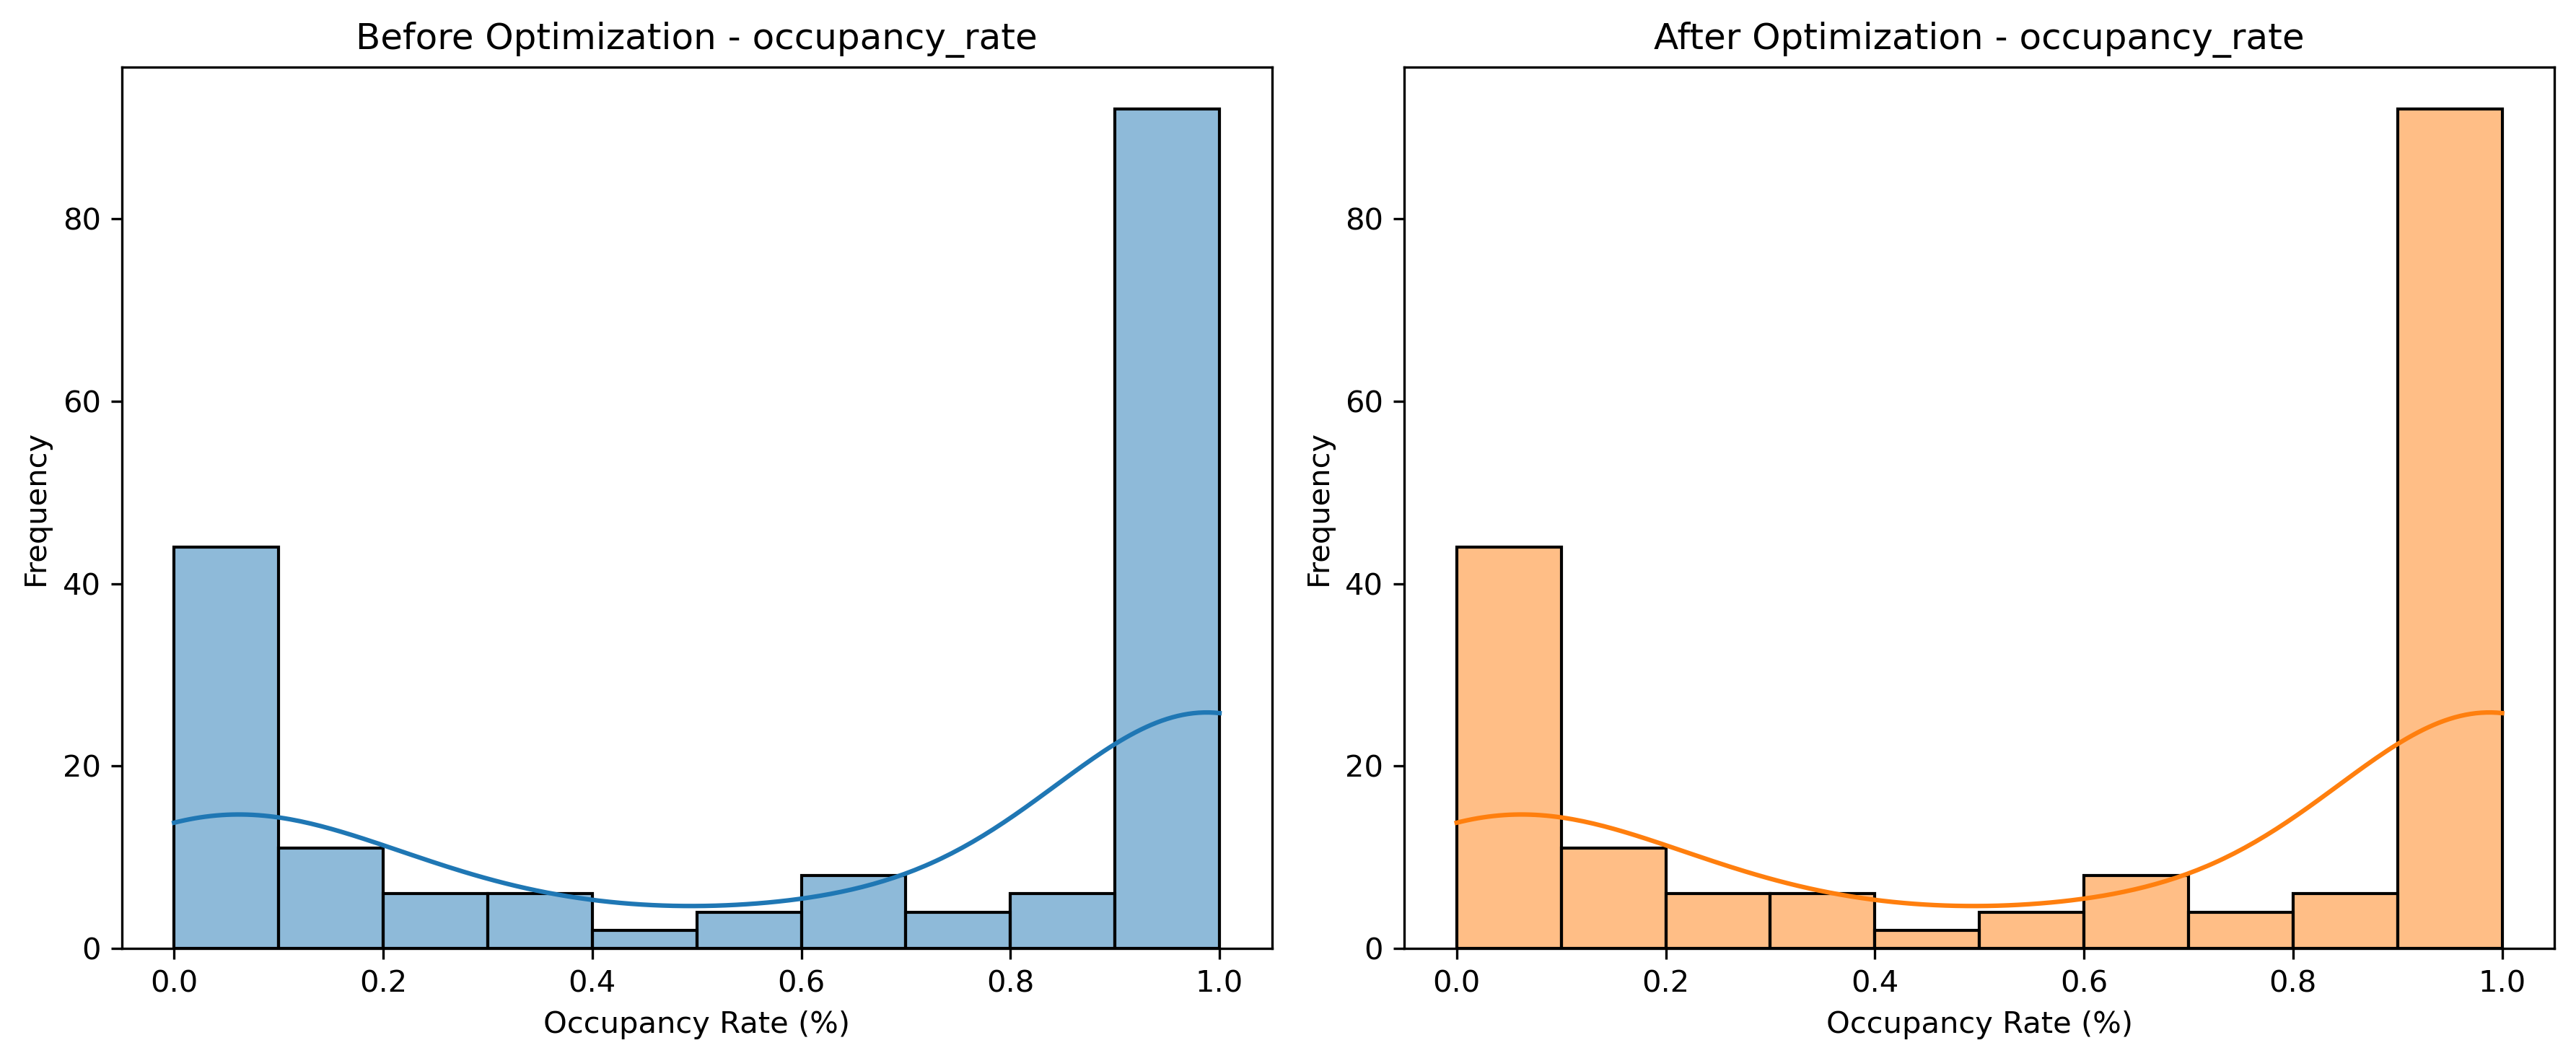

In [5]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import googlemaps
import folium
from math import radians, sin, cos, sqrt, atan2
import matplotlib as mpl
import copy
from copy import deepcopy

# Load JSON files again
building_loc_path = "data/building_loc.json"
room_timetable_path = "data/room_timetable.json"
students_info_path = "data/students_info.json"
courses_info_path = "data/courses_info.json"

with open(building_loc_path, "r") as f:
    building_loc = json.load(f)

with open(room_timetable_path, "r") as f:
    room_timetable = json.load(f)

with open(students_info_path, "r") as f:
    students_info = json.load(f)

with open(courses_info_path, "r") as f:
    courses_info = json.load(f)



# Convert courses data to DataFrame for processing
courses_df = pd.DataFrame(courses_info["courses"])


# Convert time strings to datetime
courses_df["StartTime"] = pd.to_datetime(courses_df["StartTimeStr"], format="%H:%M")
courses_df["EndTime"] = pd.to_datetime(courses_df["EndTimeStr"], format="%H:%M")

# Sort courses by time for sequential analysis
courses_df = courses_df.sort_values(by=["StartTime"])


# Haversine formula for distance calculation
def haversine_distance(coord1, coord2):
    R = 6371.0  # Earth radius in km
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in km

# Extract floor number from room number
def extract_floor(room_number):
    return int(room_number[0]) if room_number[0].isdigit() else 1

# Compute travel-related metrics
def compute_transitions(courses_df):
    transitions = []
    for i in range(len(courses_df) - 1):
        current_course = courses_df.iloc[i]
        next_course = courses_df.iloc[i + 1]

        # Ensure the gap between courses is less than 20 minutes
        time_gap = (next_course["StartTime"] - current_course["EndTime"]).total_seconds() / 60
        if time_gap < 20:
            current_building = str(int(current_course["BuildingNumber"]))
            next_building = str(int(next_course["BuildingNumber"]))

            if current_building in building_loc and next_building in building_loc:
                current_location = building_loc[current_building]
                next_location = building_loc[next_building]

                # Travel Distance & Time
                travel_distance = haversine_distance(
                    (current_location["lat"], current_location["lon"]),
                    (next_location["lat"], next_location["lon"])
                )
                walking_speed_mps = 1.4
                travel_time = (travel_distance * 1000) / walking_speed_mps / 60  # Convert to minutes

                # Floor difference
                floors_traveled = abs(extract_floor(current_course["RoomNumber"]) - extract_floor(next_course["RoomNumber"]))

                # Occupancy Rate
                occupancy_rate = current_course["NumStudents"] / current_course["RoomCapacity"] if current_course["RoomCapacity"] > 0 else 0

                transitions.append({
                    "course_1": current_course["CourseNumb"],
                    "course_2": next_course["CourseNumb"],
                    "travel_distance": travel_distance,
                    "travel_time": travel_time,
                    "floors_traveled": floors_traveled,
                    "occupancy_rate": occupancy_rate,
                    "num_students": current_course["NumStudents"]
                })
    return pd.DataFrame(transitions)

# Find the bottleneck transition (highest impact on student movement)
def find_bottleneck(transition_df, metric="travel_distance"):
    transition_df["bottleneck_score"] = transition_df[metric] * transition_df["num_students"]
    return transition_df.loc[transition_df["bottleneck_score"].idxmax()]

# Find alternative classrooms that improve metrics
def find_alternative_classroom(current_course, next_course, room_timetable):
    available_rooms = []

    for building, rooms in room_timetable.items():
        for room, schedules in rooms.items():
            # Check if the room is available
            is_available = all(
                not (schedule["StartTime"] < next_course["EndTimeStr"] and schedule["EndTime"] > next_course["StartTimeStr"])
                for schedule in schedules
            )
            if is_available:
                building_id = [k for k, v in building_loc.items() if v["name"] == building][0]
                building_data = building_loc.get(building_id)

                # Compute travel distance & time
                travel_distance = haversine_distance(
                    (building_loc[str(int(current_course["BuildingNumber"]))]["lat"],
                     building_loc[str(int(current_course["BuildingNumber"]))]["lon"]),
                    (building_data["lat"], building_data["lon"])
                )
                travel_time = (travel_distance * 1000) / 1.4 / 60

                # Floor difference
                new_floor = extract_floor(room)
                floors_traveled = abs(extract_floor(current_course["RoomNumber"]) - new_floor)

                # Store available room
                available_rooms.append({
                    "room": room,
                    "building": building,
                    "building_id": building_id,
                    "travel_distance": travel_distance,
                    "travel_time": travel_time,
                    "floors_traveled": floors_traveled
                })

    if available_rooms:
        return min(available_rooms, key=lambda x: (x["travel_distance"], x["travel_time"], x["floors_traveled"]))
    return None

# Iterative Optimization Process
def iterative_optimization(courses_df, room_timetable, iterations=3):
    for _ in range(iterations):
        transitions_df = compute_transitions(courses_df)
        bottleneck = find_bottleneck(transitions_df)

        # Find alternative
        current_course = courses_df[courses_df["CourseNumb"] == bottleneck["course_1"]].iloc[0]
        next_course = courses_df[courses_df["CourseNumb"] == bottleneck["course_2"]].iloc[0]
        alternative = find_alternative_classroom(current_course, next_course, room_timetable)

        if alternative:
            # Release the original room
            original_building = next_course["BuildingName"]
            original_room = next_course["RoomNumber"]
            room_timetable[original_building][original_room] = []  # Mark as available

            # Assign new room
            courses_df.loc[courses_df["CourseNumb"] == bottleneck["course_2"], "BuildingName"] = alternative["building"]
            courses_df.loc[courses_df["CourseNumb"] == bottleneck["course_2"], "RoomNumber"] = alternative["room"]

            # Update the room timetable
            room_timetable[alternative["building"]][alternative["room"]] = [{
                "StartTime": next_course["StartTimeStr"],
                "EndTime": next_course["EndTimeStr"]
            }]
    return courses_df

# Run Optimization
before_optimization = compute_transitions(courses_df)
optimized_courses = iterative_optimization(courses_df, room_timetable, iterations=3)
after_optimization = compute_transitions(optimized_courses)

# Run Optimization
before_optimization = compute_transitions(courses_df)
optimized_courses = iterative_optimization(courses_df, room_timetable, iterations=3)
after_optimization = compute_transitions(optimized_courses)

# Plot results with mean lines
for metric, xlabel in zip(
    ["travel_distance", "travel_time", "floors_traveled", "occupancy_rate"],
    ["Distance (km)", "Time (minutes)", "Floors", "Occupancy Rate (%)"]
):
    plot_metrics(before_optimization[metric], after_optimization[metric], metric, xlabel)


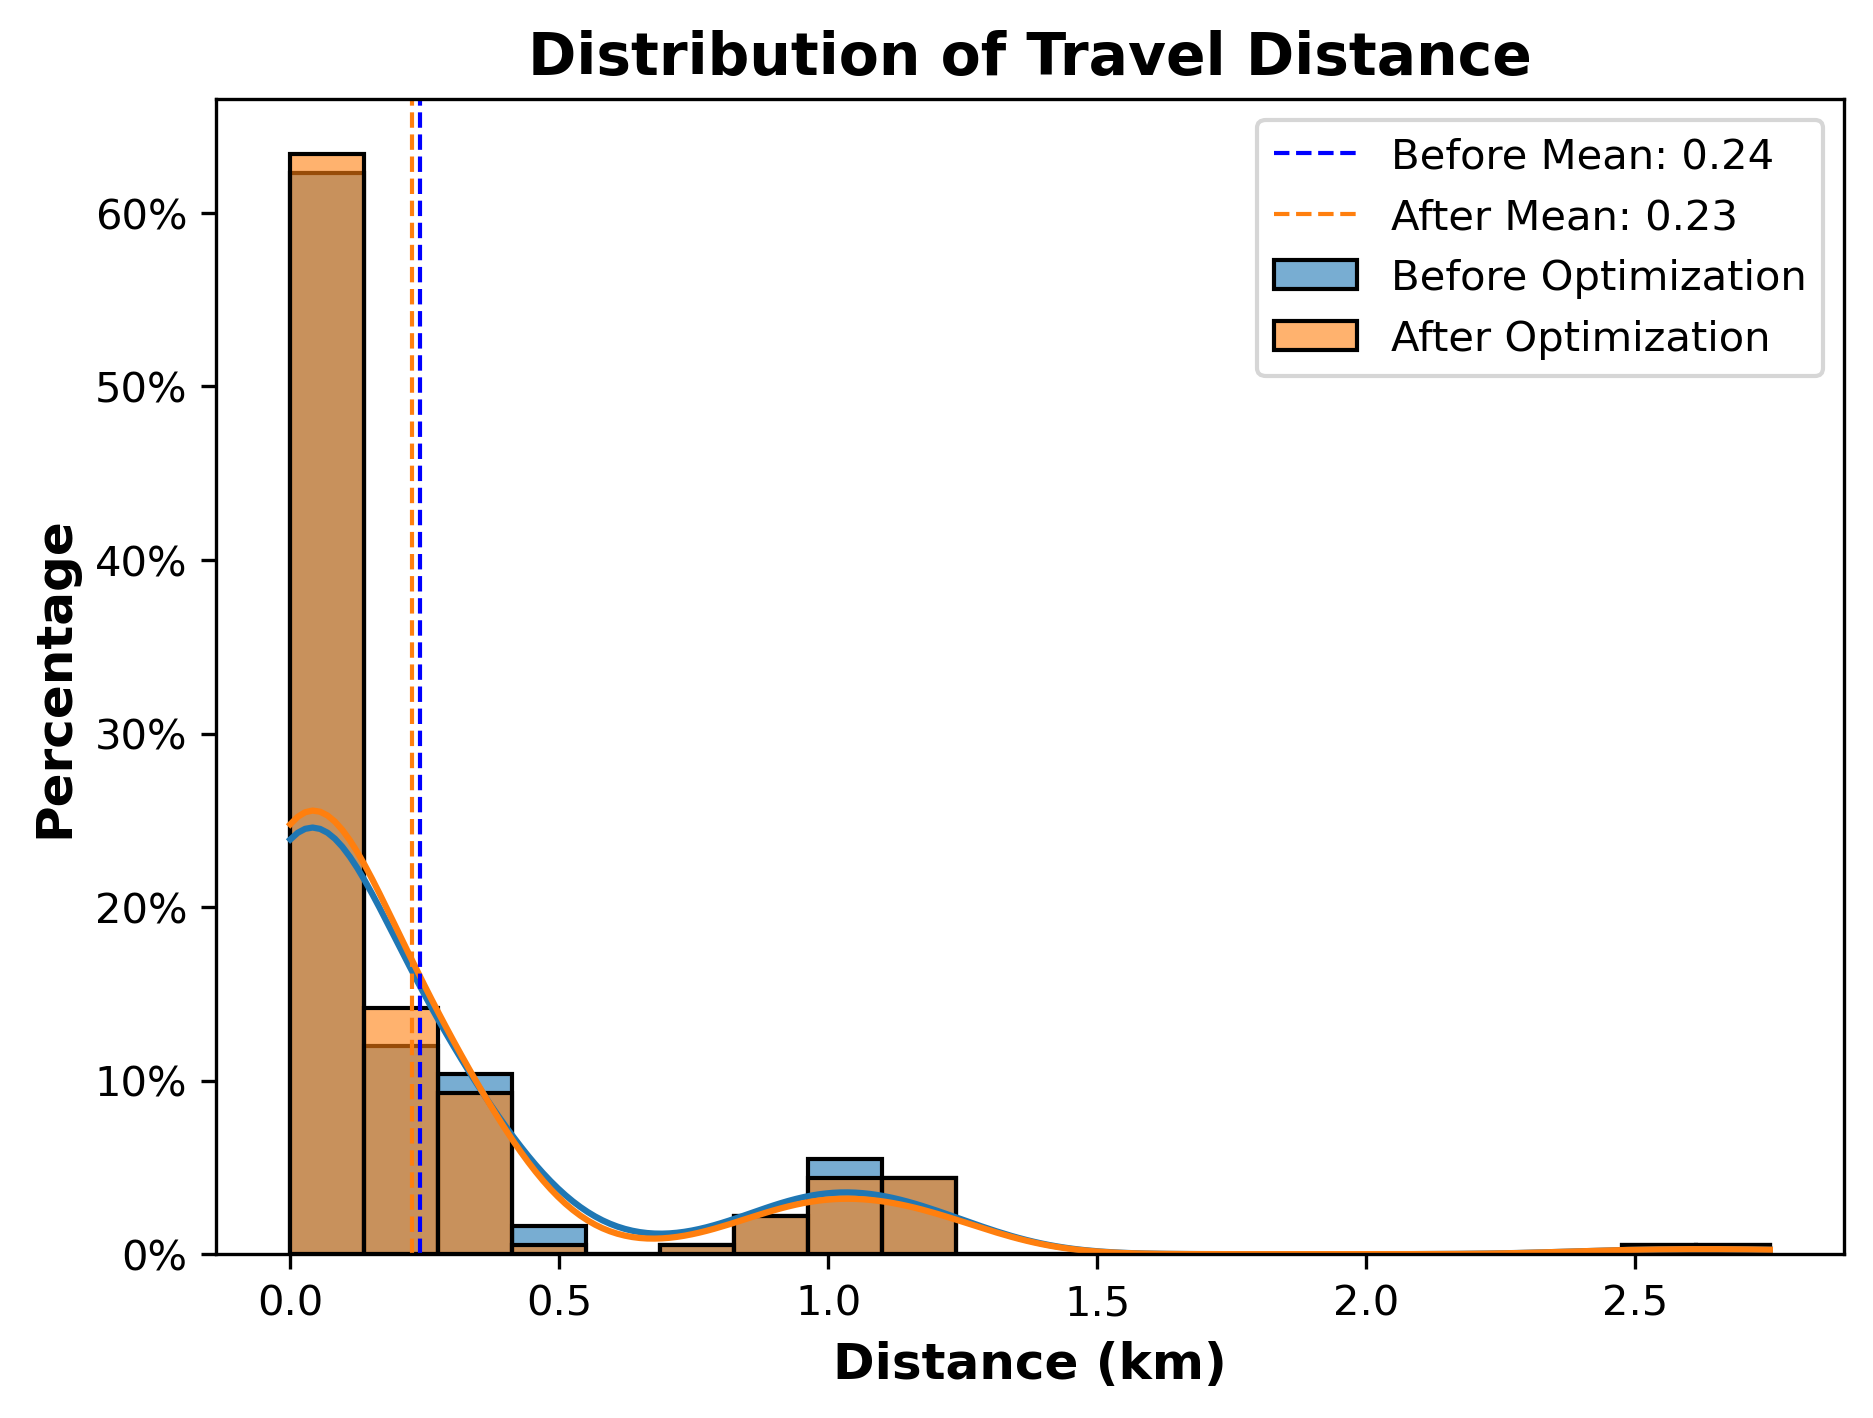

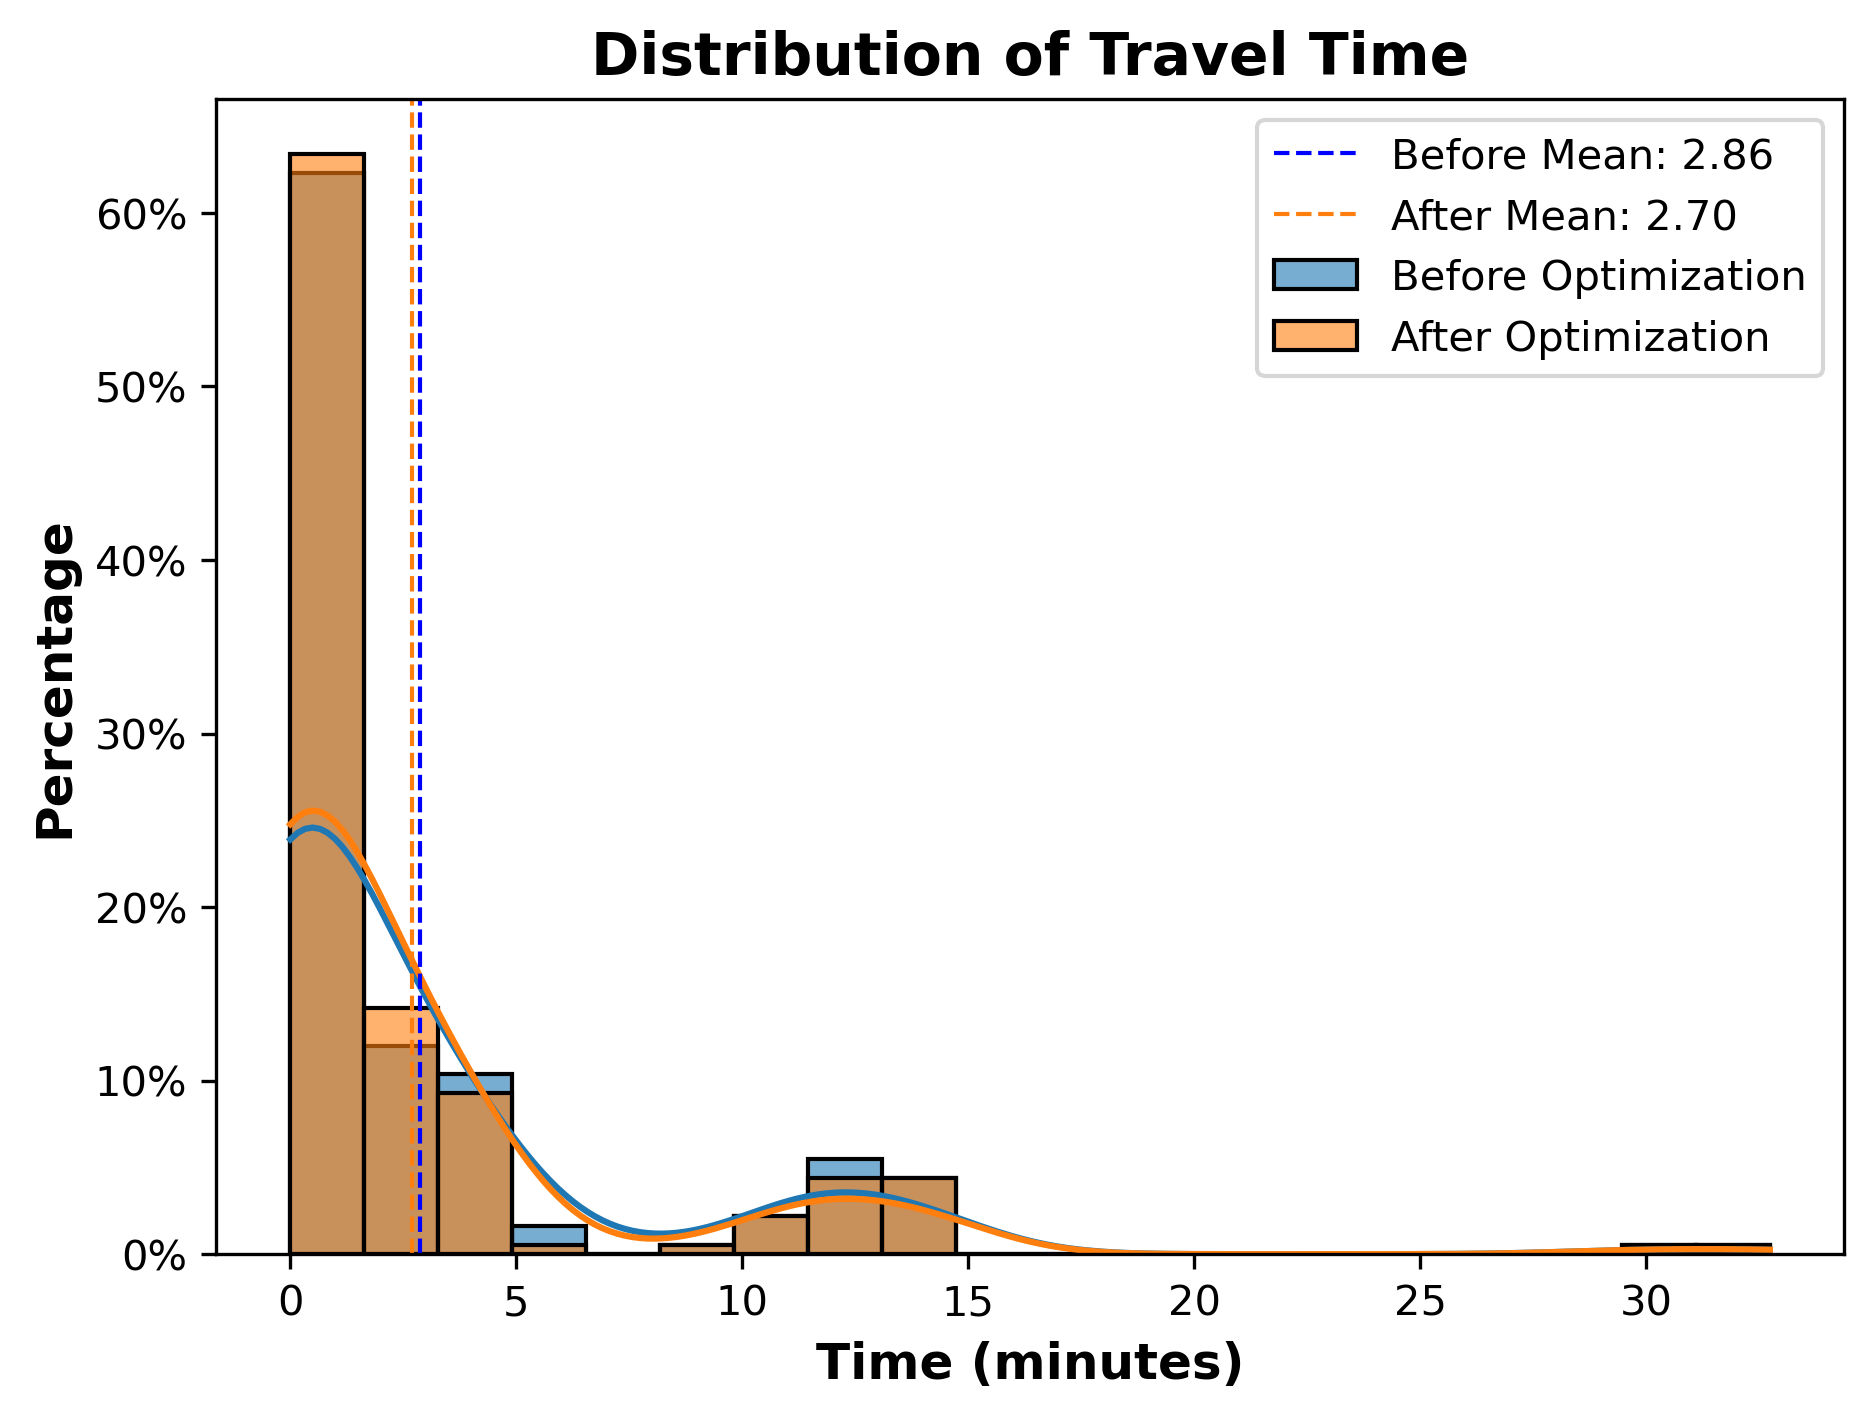

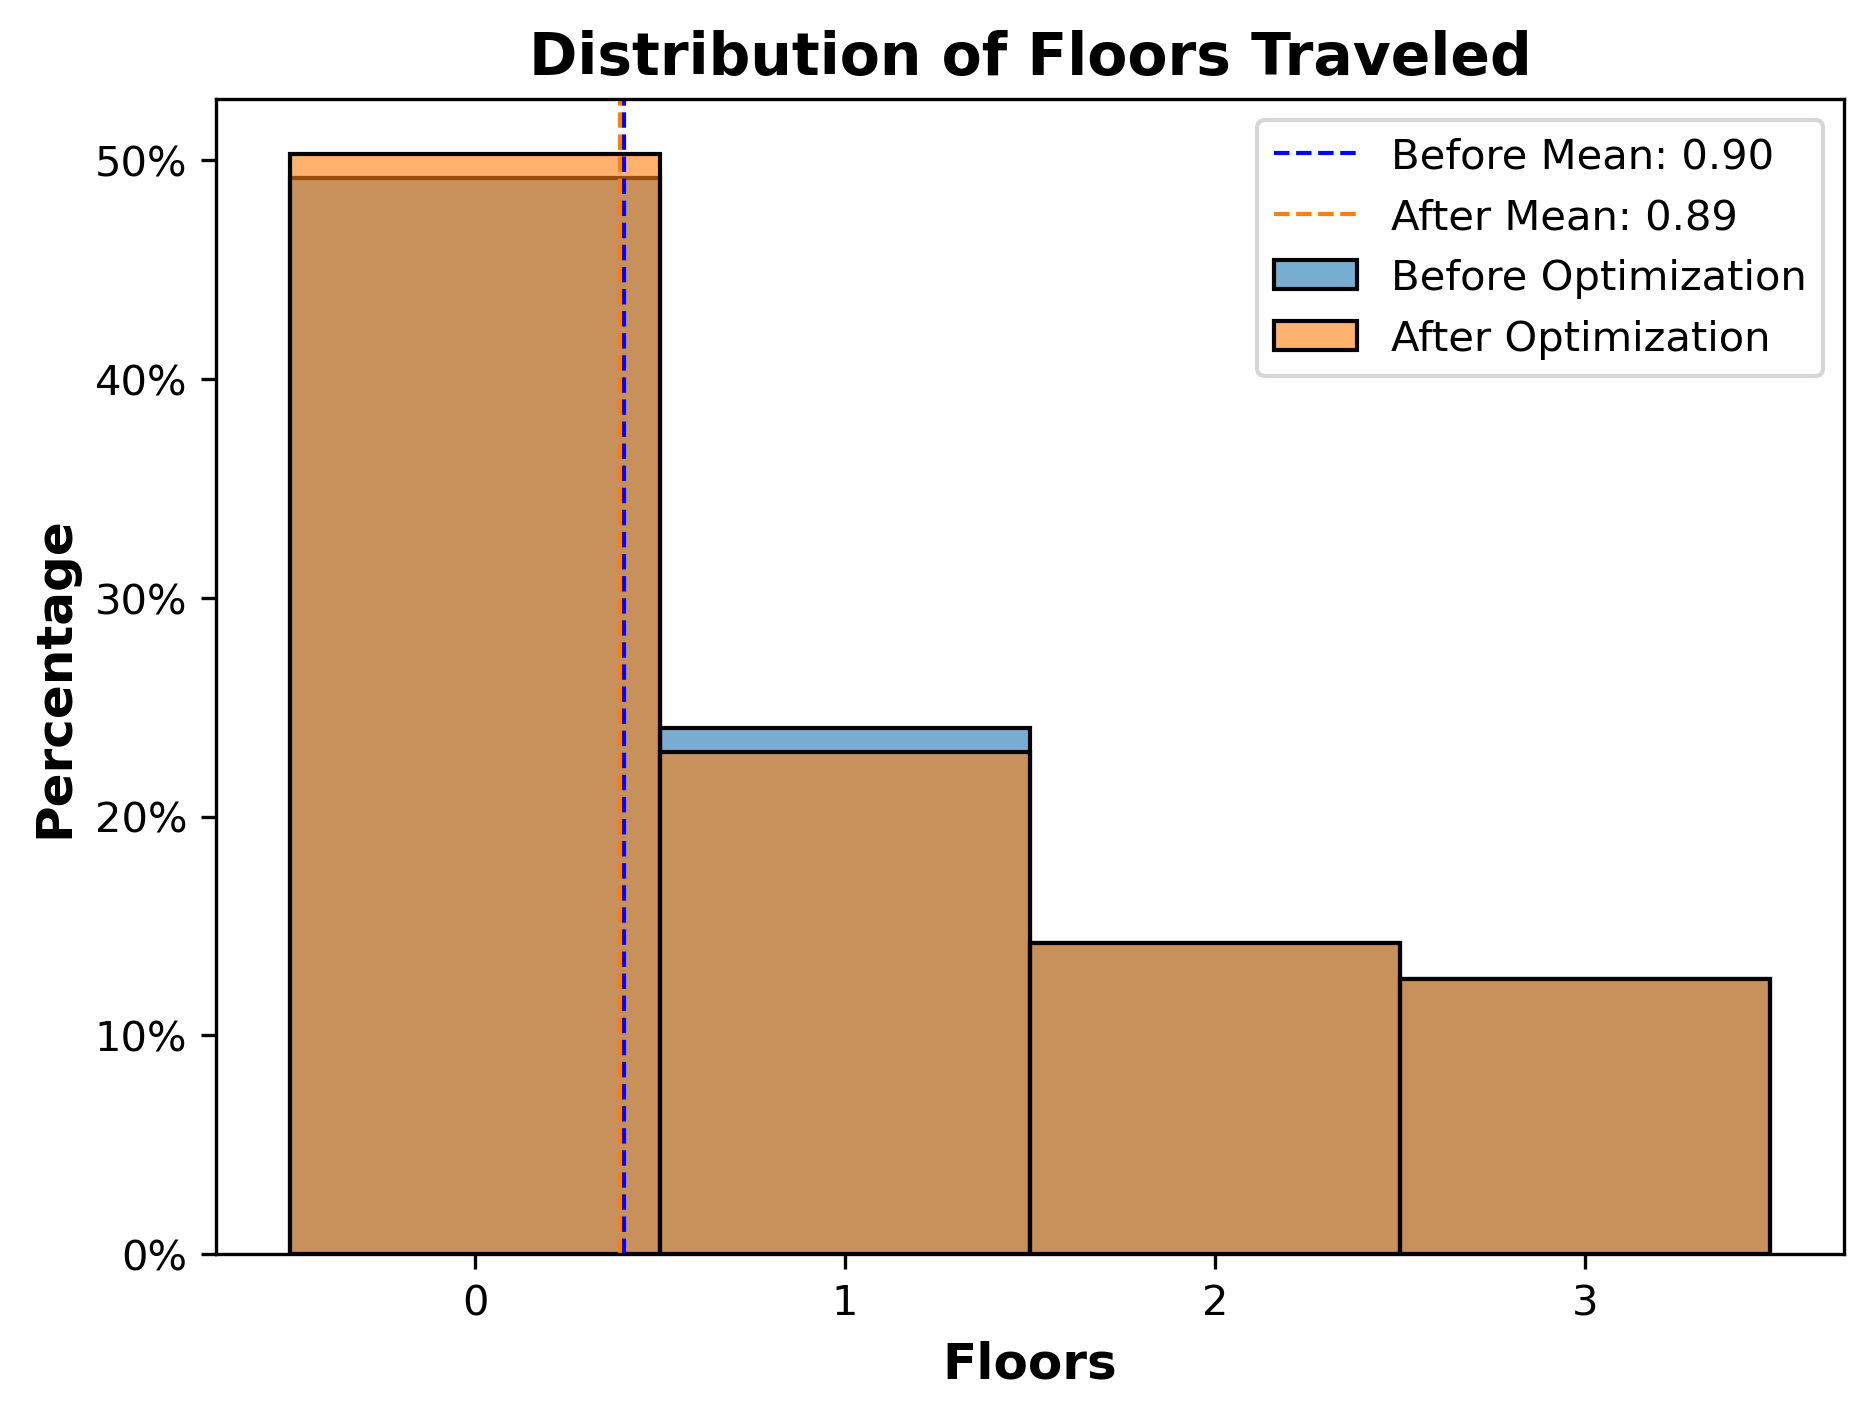

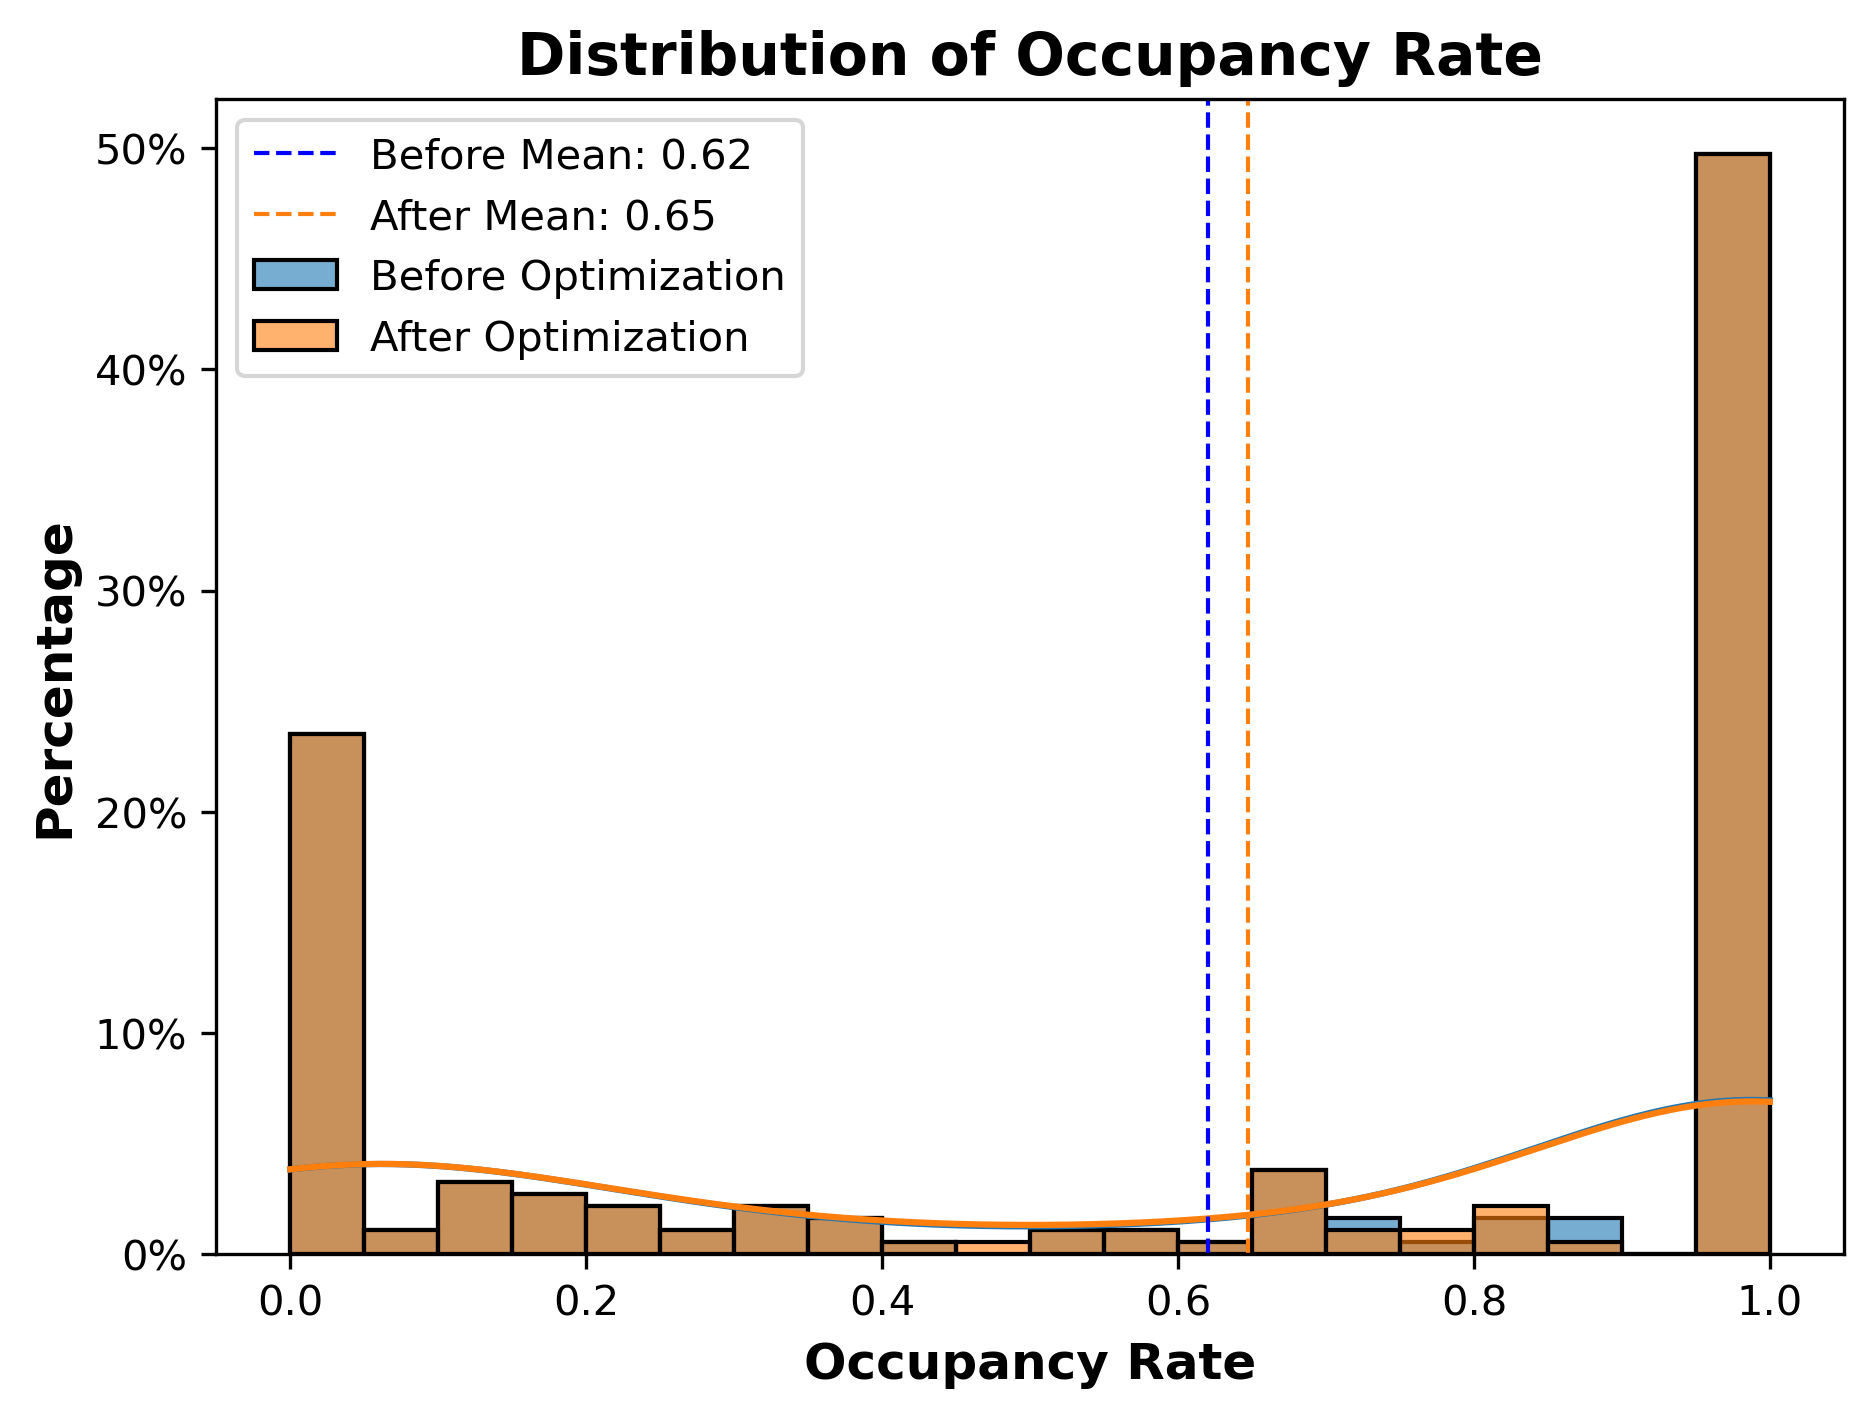

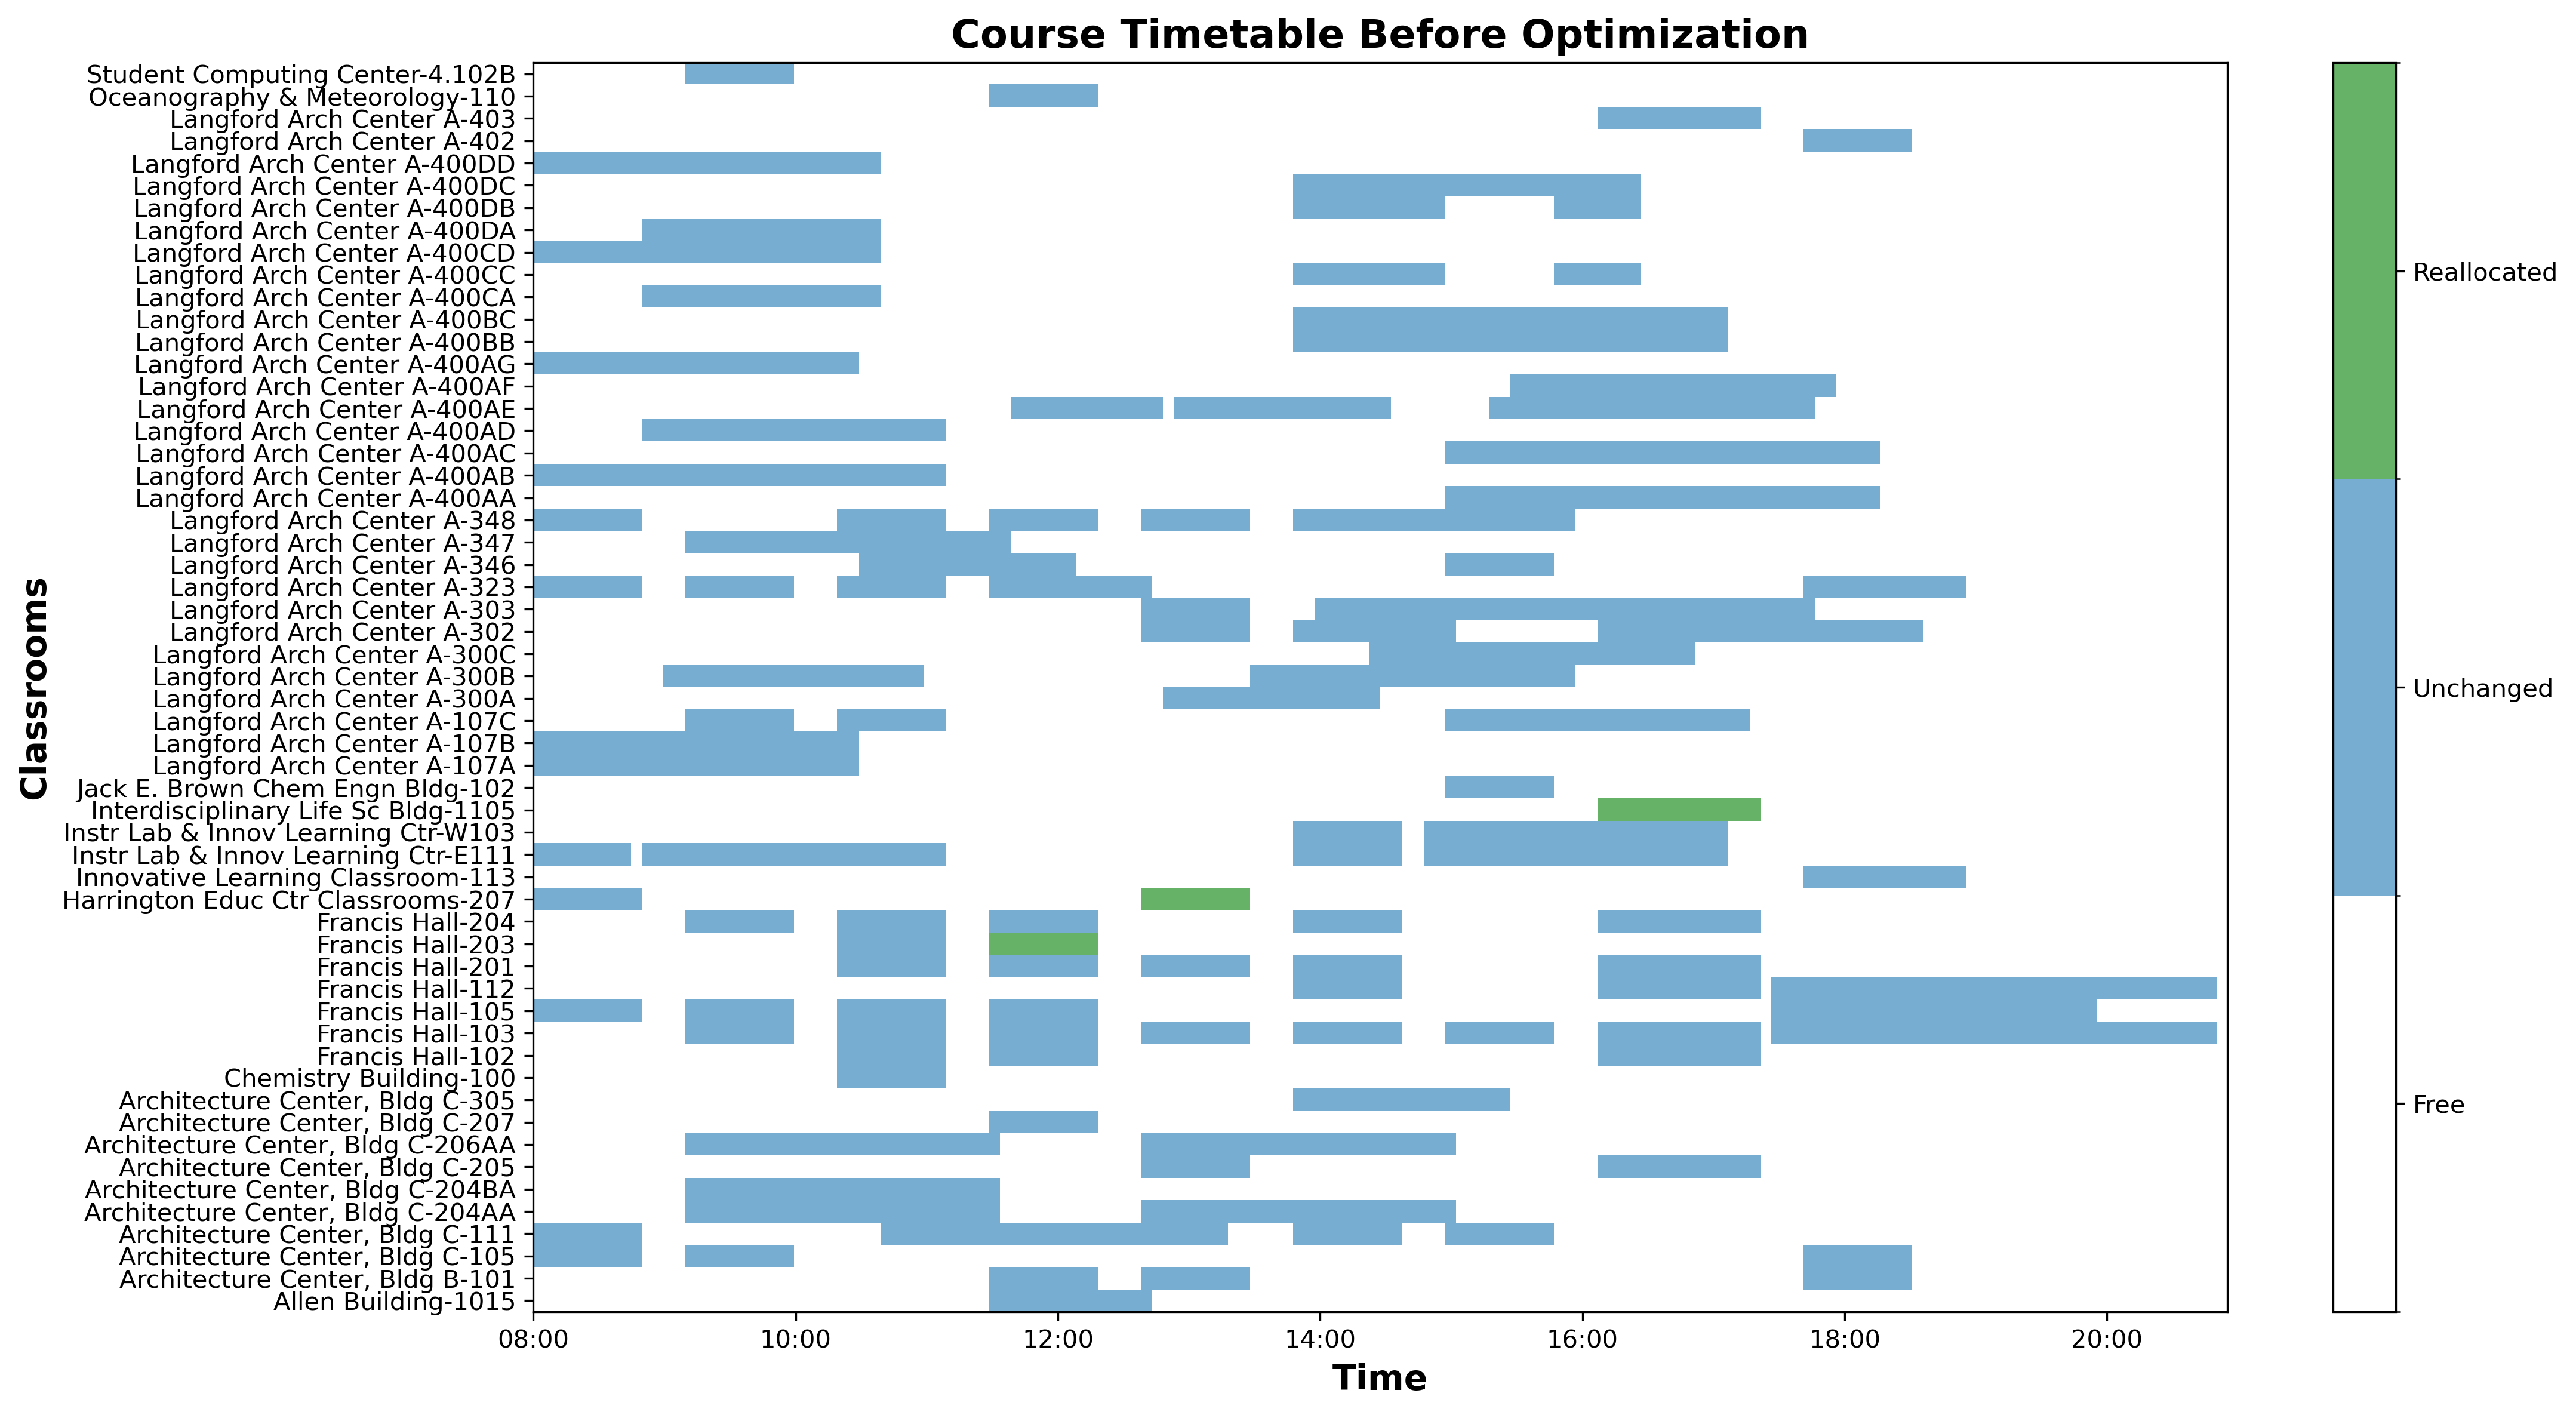

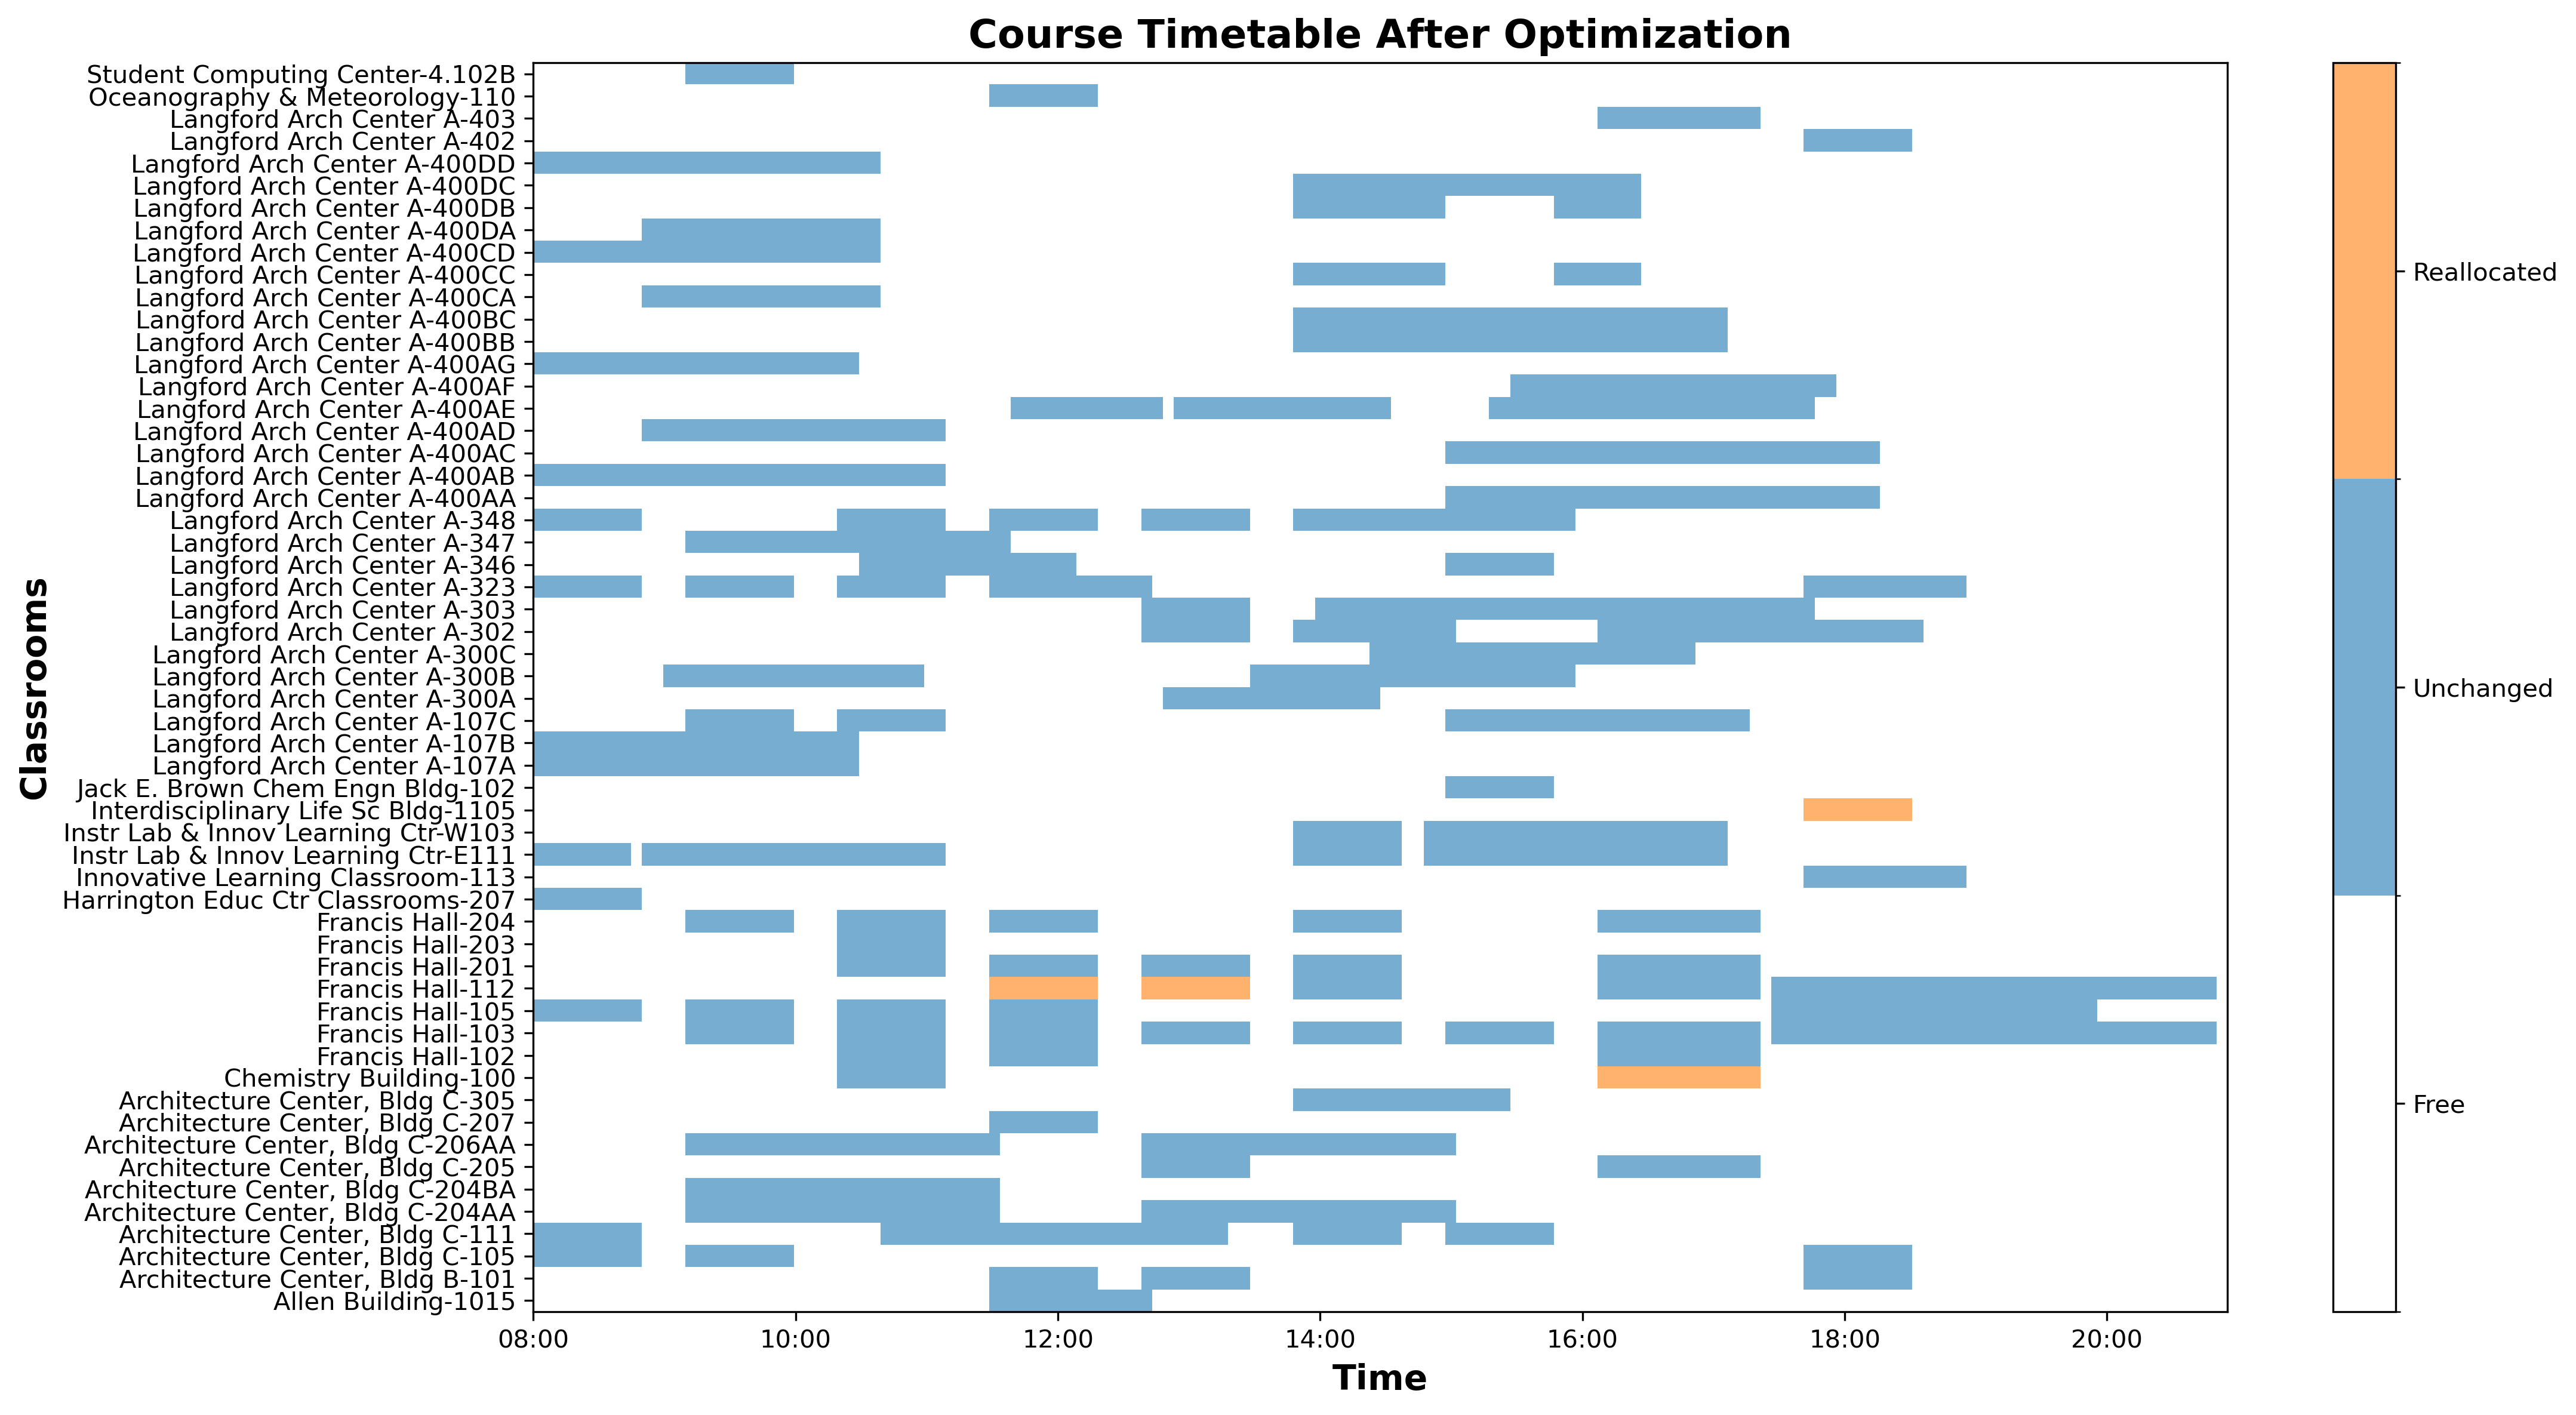

In [7]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from math import radians, sin, cos, sqrt, atan2
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates

# ============================
# 1. Load Input Data
# ============================
building_loc_path = "data/building_loc.json"
room_timetable_path = "data/room_timetable.json"
students_info_path = "data/students_info.json"
courses_info_path = "data/courses_info.json"

with open(building_loc_path, "r") as f:
    building_loc = json.load(f)

with open(room_timetable_path, "r") as f:
    room_timetable = json.load(f)

with open(students_info_path, "r") as f:
    students_info = json.load(f)

with open(courses_info_path, "r") as f:
    courses_info = json.load(f)

# Convert courses data to DataFrame
courses_df = pd.DataFrame(courses_info["courses"])

# Convert time strings to datetime objects for proper sorting and gap calculation
courses_df["StartTime"] = pd.to_datetime(courses_df["StartTimeStr"], format="%H:%M")
courses_df["EndTime"] = pd.to_datetime(courses_df["EndTimeStr"], format="%H:%M")
courses_df = courses_df.sort_values(by=["StartTime"])

# ============================
# 1a. Build a Room Capacity Mapping
# ============================
# Map (BuildingName, RoomNumber) to RoomCapacity from courses_info.
room_capacity_mapping = {}
for _, row in courses_df.iterrows():
    building = row.get("BuildingName", str(row["BuildingNumber"]))
    room = row["RoomNumber"]
    capacity = row["RoomCapacity"]
    room_capacity_mapping[(building, room)] = capacity

# ============================
# 2. Helper Functions
# ============================
def haversine_distance(coord1, coord2):
    """Calculate the great-circle distance between two coordinates."""
    R = 6371.0  # Earth radius in km
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def extract_floor(room_number):
    """Extract the floor number from a room identifier (assumes first digit represents the floor)."""
    return int(room_number[0]) if room_number and room_number[0].isdigit() else 1

# ============================
# 3. Compute Transitions
# ============================
def compute_transitions(courses_df):
    """
    Compute travel metrics for transitions between consecutive courses that
    have less than a 20-minute gap. Here, occupancy rate is computed for course 2.
    """
    transitions = []
    for i in range(len(courses_df) - 1):
        current_course = courses_df.iloc[i]
        next_course = courses_df.iloc[i+1]
        time_gap = (next_course["StartTime"] - current_course["EndTime"]).total_seconds() / 60
        if time_gap < 20:
            current_building = str(int(current_course["BuildingNumber"]))
            next_building = str(int(next_course["BuildingNumber"]))
            if current_building in building_loc and next_building in building_loc:
                current_loc = (building_loc[current_building]["lat"], building_loc[current_building]["lon"])
                next_loc = (building_loc[next_building]["lat"], building_loc[next_building]["lon"])
                travel_distance = haversine_distance(current_loc, next_loc)
                walking_speed = 1.4  # m/s
                travel_time = (travel_distance * 1000) / walking_speed / 60  # minutes
                floors_traveled = abs(extract_floor(current_course["RoomNumber"]) - extract_floor(next_course["RoomNumber"]))
                # Compute occupancy rate for course 2 (which may be reallocated)
                occupancy_rate = (next_course["NumStudents"] / next_course["RoomCapacity"]) if next_course["RoomCapacity"] > 0 else 0

                transitions.append({
                    "course_1": current_course["CourseNumb"],
                    "course_2": next_course["CourseNumb"],
                    "travel_distance": travel_distance,
                    "travel_time": travel_time,
                    "floors_traveled": floors_traveled,
                    "occupancy_rate": occupancy_rate,
                    "num_students": next_course["NumStudents"]
                })
    return pd.DataFrame(transitions)

# ============================
# 4. Bottleneck Identification
# ============================
def find_bottleneck(transition_df, metric="travel_distance"):
    """Identify the transition with the highest student-weighted travel metric."""
    if transition_df.empty:
        return None
    df = transition_df.copy()
    df["bottleneck_score"] = df[metric] * df["num_students"]
    return df.loc[df["bottleneck_score"].idxmax()]

# ============================
# 5. Finding Alternative Classrooms
# ============================
def find_alternative_classroom(current_course, next_course, room_timetable):
    """
    Find an available classroom for next_course.
    Only candidate rooms whose capacity (looked up from courses_info)
    can accommodate next_course["NumStudents"] are considered.
    """
    available_rooms = []
    required_students = next_course["NumStudents"]
    
    for building, rooms in room_timetable.items():
        for room, schedules in rooms.items():
            # Check if the room is available during next_course time slot.
            is_available = True
            for schedule in schedules:
                if schedule["StartTime"] < next_course["EndTimeStr"] and schedule["EndTime"] > next_course["StartTimeStr"]:
                    is_available = False
                    break
            if is_available:
                # Retrieve the building id from building_loc using the building name.
                building_ids = [k for k, v in building_loc.items() if v.get("name") == building]
                if not building_ids:
                    continue
                building_id = building_ids[0]
                building_data = building_loc[building_id]
                current_building_id = str(int(current_course["BuildingNumber"]))
                current_building_data = building_loc.get(current_building_id)
                if current_building_data is None:
                    continue
                
                travel_distance = haversine_distance(
                    (current_building_data["lat"], current_building_data["lon"]),
                    (building_data["lat"], building_data["lon"])
                )
                walking_speed = 1.4
                travel_time = (travel_distance * 1000) / walking_speed / 60
                floors_traveled = abs(extract_floor(current_course["RoomNumber"]) - extract_floor(room))
                
                # Look up the candidate room's capacity from courses_info.
                candidate_capacity = room_capacity_mapping.get((building, room), None)
                if candidate_capacity is None:
                    continue
                # Enforce the capacity constraint.
                if candidate_capacity < required_students:
                    continue
                
                available_rooms.append({
                    "room": room,
                    "building": building,
                    "building_id": building_id,  # used for travel metric lookup
                    "travel_distance": travel_distance,
                    "travel_time": travel_time,
                    "floors_traveled": floors_traveled,
                    "room_capacity": candidate_capacity
                })
    if available_rooms:
        # Choose the candidate with the lowest travel impact.
        return min(available_rooms, key=lambda x: (x["travel_distance"], x["travel_time"], x["floors_traveled"]))
    return None

# ============================
# 6. Visualization Function (Metrics)
# ============================
def plot_metrics(before, after, metric, xlabel):
    """
    Plot the distributions before and after optimization.
    
    - All y-axis tick labels include a '%' sign.
    - For floors_traveled, use integer bins and center ticks on the bars.
    - For occupancy_rate, clip values and means to [0,1] before plotting.
    """
    plt.figure(figsize=(7, 5))

    titles = {
        "travel_distance": "Travel Distance", 
        "travel_time": "Travel Time", 
        "floors_traveled": "Floors Traveled", 
        "occupancy_rate": "Occupancy Rate"
    }

    # Add vertical mean lines.
    mean_before = before.mean()
    mean_after = after.mean()

    if metric == "floors_traveled":
        # Use integer bins for floors_traveled
        min_val = int(min(before.min(), after.min()))
        max_val = int(max(before.max(), after.max()))
        bins = range(min_val, max_val + 2)  # bins from min to max+1
        ax = sns.histplot(before, color="#1f77b4", label="Before Optimization", stat="percent", bins=bins, alpha=0.6)
        sns.histplot(after, color="#ff7f0e", label="After Optimization", stat="percent", bins=bins, alpha=0.6, ax=ax)
        # Set x-ticks at the center of each bin.
        centers = [x + 0.5 for x in bins[:-1]]
        ax.set_xticks(centers)
        ax.set_xticklabels([str(x) for x in range(min_val, max_val + 1)])
    elif metric == "travel_distance" or metric ==  "travel_time":
        ax = sns.histplot(before, color="#1f77b4", label="Before Optimization", kde=True, stat="percent", bins=20, alpha=0.6)
        sns.histplot(after, color="#ff7f0e", label="After Optimization", kde=True, stat="percent", bins=20, alpha=0.6, ax=ax)
    else:
        before = before.clip(upper=1)
        after = after.clip(upper=1)
        ax = sns.histplot(before, color="#1f77b4", label="Before Optimization", kde=True, stat="percent", bins=20, alpha=0.6)
        sns.histplot(after, color="#ff7f0e", label="After Optimization", kde=True, stat="percent", bins=20, alpha=0.6, ax=ax)
        mean_before = max(0, min(mean_before, 1))
        mean_after = max(0, min(mean_after, 1))

    ax.axvline(mean_before, color="blue", linestyle="dashed", linewidth=1, label=f"Before Mean: {mean_before:.2f}")
    ax.axvline(mean_after, color="#ff7f0e", linestyle="dashed", linewidth=1, label=f"After Mean: {mean_after:.2f}")

    
    plt.xlabel(xlabel, fontsize=12, fontweight="bold")
    plt.ylabel("Percentage", fontsize=12, fontweight="bold")
    plt.title(f"Distribution of {titles[metric]}", fontsize=14, fontweight="bold")
    plt.legend()
    
    # Format y-axis ticks to include '%'
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.show()

# ============================
# 7. Iterative Optimization Process
# ============================
def iterative_optimization(courses_df, room_timetable, iterations=3):
    """
    Iteratively reassign the course (course 2) in the highest-impact transition
    to a new available classroom.
    
    The new assignment updates BuildingName, RoomNumber, BuildingNumber,
    and RoomCapacity. Also, the room timetable is updated by releasing the original room.
    """
    opt_courses_df = courses_df.copy(deep=True)
    opt_room_timetable = copy.deepcopy(room_timetable)
    optimization_log = []

    for it in range(iterations):
        transitions_df = compute_transitions(opt_courses_df)
        if transitions_df.empty:
            print("No valid transitions found. Ending optimization.")
            break
        bottleneck = find_bottleneck(transitions_df)
        if bottleneck is None:
            print("No bottleneck found. Ending optimization.")
            break

        # Identify the two courses in the transition.
        current_course = opt_courses_df[opt_courses_df["CourseNumb"] == bottleneck["course_1"]].iloc[0]
        next_course = opt_courses_df[opt_courses_df["CourseNumb"] == bottleneck["course_2"]].iloc[0]

        alternative = find_alternative_classroom(current_course, next_course, opt_room_timetable)
        log_entry = {
            "iteration": it + 1,
            "bottleneck": bottleneck.to_dict(),
            "course_2_original": {
                "BuildingName": next_course.get("BuildingName", str(next_course["BuildingNumber"])),
                "RoomNumber": next_course["RoomNumber"],
                "RoomCapacity": next_course["RoomCapacity"],
                "StartTimeStr": next_course["StartTimeStr"],
                "EndTimeStr": next_course["EndTimeStr"]
            }
        }

        if alternative:
            log_entry["alternative_selected"] = alternative
            # Release the original room (make the time slot available).
            original_building = next_course.get("BuildingName", str(next_course["BuildingNumber"]))
            original_room = next_course["RoomNumber"]
            if original_building in opt_room_timetable and original_room in opt_room_timetable[original_building]:
                opt_room_timetable[original_building][original_room] = [
                    sched for sched in opt_room_timetable[original_building][original_room]
                    if not (sched["StartTime"] == next_course["StartTimeStr"] and sched["EndTime"] == next_course["EndTimeStr"])
                ]
            
            # Reassign course 2 to the new alternative room and update all related fields.
            opt_courses_df.loc[opt_courses_df["CourseNumb"] == bottleneck["course_2"], "BuildingName"] = alternative["building"]
            opt_courses_df.loc[opt_courses_df["CourseNumb"] == bottleneck["course_2"], "RoomNumber"] = alternative["room"]
            opt_courses_df.loc[opt_courses_df["CourseNumb"] == bottleneck["course_2"], "BuildingNumber"] = alternative["building_id"]
            opt_courses_df.loc[opt_courses_df["CourseNumb"] == bottleneck["course_2"], "RoomCapacity"] = alternative["room_capacity"]

            # Verify that enrollment does not exceed the new room capacity.
            updated_course = opt_courses_df[opt_courses_df["CourseNumb"] == bottleneck["course_2"]].iloc[0]
            if updated_course["NumStudents"] > updated_course["RoomCapacity"]:
                print(f"Error: Enrollment {updated_course['NumStudents']} exceeds room capacity {updated_course['RoomCapacity']} for course {updated_course['CourseNumb']}.")
            
            # Update the room timetable for the new room.
            if alternative["building"] in opt_room_timetable:
                if alternative["room"] in opt_room_timetable[alternative["building"]]:
                    opt_room_timetable[alternative["building"]][alternative["room"]].append({
                        "StartTime": next_course["StartTimeStr"],
                        "EndTime": next_course["EndTimeStr"]
                    })
                else:
                    opt_room_timetable[alternative["building"]][alternative["room"]] = [{
                        "StartTime": next_course["StartTimeStr"],
                        "EndTime": next_course["EndTimeStr"]
                    }]
            else:
                opt_room_timetable[alternative["building"]] = {
                    alternative["room"]: [{
                        "StartTime": next_course["StartTimeStr"],
                        "EndTime": next_course["EndTimeStr"]
                    }]
                }
        else:
            log_entry["alternative_selected"] = "No alternative found"
        optimization_log.append(log_entry)
    return opt_courses_df, opt_room_timetable, optimization_log

# ============================
# 8. Run Optimization & Visualize Metrics
# ============================
before_optimization = compute_transitions(courses_df)
optimized_courses_df, updated_room_timetable, optimization_log = iterative_optimization(courses_df, room_timetable, iterations=3)
after_optimization = compute_transitions(optimized_courses_df)

for metric, xlabel in zip(
    ["travel_distance", "travel_time", "floors_traveled", "occupancy_rate"],
    ["Distance (km)", "Time (minutes)", "Floors", "Occupancy Rate"]
):
    if metric in before_optimization and metric in after_optimization:
        plot_metrics(before_optimization[metric], after_optimization[metric], metric, xlabel)

final_output = {
    "original_assignments": courses_df.to_dict(orient="records"),
    "updated_assignments": optimized_courses_df.to_dict(orient="records"),
    "optimization_log": optimization_log,
    "updated_room_timetable": updated_room_timetable
}

# print(json.dumps(final_output, indent=4))

# ============================
# 9. Additional: Plot Course Timetables (Before vs. After)
# ============================

# ============================
# 9. Additional: Plot Course Timetables (Before vs. After) in Separate Plots
# ============================

import matplotlib.colors as mcolors

def create_timetable_matrix(courses, time_range, classroom_list, reallocated_ids=None, reallocated_value=2):
    """
    Build a 0-1 matrix with index=classroom_list and columns=time_range.
    For each course, fill in cells corresponding to its time interval with:
      - 1 if the course is scheduled and unchanged,
      - reallocated_value if the course is reallocated (its CourseNumb is in reallocated_ids).
    """
    timetable = pd.DataFrame(0, index=classroom_list, columns=time_range)
    for idx, course in courses.iterrows():
        building = course.get("BuildingName", str(course["BuildingNumber"]))
        room = course["RoomNumber"]
        classroom = f"{building}-{room}"
        start_time = course["StartTime"]
        end_time = course["EndTime"]
        mask = (time_range >= start_time) & (time_range < end_time)
        value = 1  # unchanged course
        if reallocated_ids is not None and course["CourseNumb"] in reallocated_ids:
            value = reallocated_value
        if classroom in classroom_list:
            timetable.loc[classroom, mask] = value
    return timetable

# Determine overall time range and unique classroom list from both original and updated assignments.
all_courses = pd.concat([courses_df, optimized_courses_df])
min_time = all_courses["StartTime"].min()
max_time = all_courses["EndTime"].max()
time_range = pd.date_range(start=min_time.floor("5T"), end=max_time.ceil("5T"), freq="5T")

def get_classroom_identifier(course):
    building = course.get("BuildingName", str(course["BuildingNumber"]))
    room = course["RoomNumber"]
    return f"{building}-{room}"

original_classrooms = courses_df.apply(get_classroom_identifier, axis=1).unique().tolist()
updated_classrooms = optimized_courses_df.apply(get_classroom_identifier, axis=1).unique().tolist()
classroom_list = sorted(list(set(original_classrooms) | set(updated_classrooms)))

# Determine which courses were reallocated (i.e. whose classroom changed).
original_assignments = courses_df.set_index("CourseNumb").apply(lambda r: f"{r.get('BuildingName', str(r['BuildingNumber']))}-{r['RoomNumber']}", axis=1).to_dict()
updated_assignments = optimized_courses_df.set_index("CourseNumb").apply(lambda r: f"{r.get('BuildingName', str(r['BuildingNumber']))}-{r['RoomNumber']}", axis=1).to_dict()
reallocated_ids = {cid for cid in original_assignments if original_assignments[cid] != updated_assignments.get(cid, None)}

# Create timetable matrices:
# For the BEFORE plot, assign reallocated courses the value 2.
timetable_before = create_timetable_matrix(courses_df, time_range, classroom_list, reallocated_ids, reallocated_value=2)
# For the AFTER plot, assign reallocated courses the value 3.
timetable_after = create_timetable_matrix(optimized_courses_df, time_range, classroom_list, reallocated_ids, reallocated_value=3)
# For the AFTER plot, remap the matrix so that:
#   0 remains 0, 1 remains 1, and value 3 is mapped to 2 (to make colormap indexing contiguous).
timetable_after_mapped = timetable_after.replace({3:2})

# We'll use a BoundaryNorm with boundaries that split [0,1] into three equal sections.
boundaries = [0, 0.33, 0.67, 1]
norm = mcolors.BoundaryNorm(boundaries, ncolors=3)

# Define the tick positions at the centers of each section: 
# centers = (0 + 0.33)/2 ≈ 0.165, (0.33 + 0.67)/2 = 0.5, (0.67 + 1)/2 ≈ 0.835.
tick_positions = [0.165, 0.5, 0.835]

# ----------------------------
# Plot the BEFORE timetable in a separate plot.
# ----------------------------
plt.figure(figsize=(15, 8))
# We divide by 2 so that 0 -> 0, 1 -> 0.5, 2 -> 1 in the normalized scale.
cmap_before = ListedColormap(["white", "#1f77b4", "green"])  # 0: free, 1: unchanged, 2: reallocated (before)
im_before = plt.imshow(timetable_before.values/2, aspect="auto", cmap=cmap_before, norm=norm, origin="lower",
                extent=[mdates.date2num(time_range[0]), mdates.date2num(time_range[-1]), 0, len(classroom_list)], alpha=0.6)
plt.title("Course Timetable Before Optimization", fontsize=16, fontweight="bold")
plt.ylabel("Classrooms", fontsize=14, fontweight="bold")
plt.yticks(np.arange(0.5, len(classroom_list), 1), classroom_list)
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Time", fontsize=14, fontweight="bold")
cbar_before = plt.colorbar(im_before)
cbar_before.set_ticks(tick_positions)
cbar_before.ax.set_yticklabels(['Free','Unchanged','Reallocated'])
plt.tight_layout()
plt.show()

# ----------------------------
# Plot the AFTER timetable in a separate plot.
# ----------------------------
plt.figure(figsize=(15, 8))
cmap_after = ListedColormap(["white", "#1f77b4", "#ff7f0e"])  # 0: free, 1: unchanged, 2: reallocated (after)
im_after = plt.imshow(timetable_after_mapped.values/2, aspect="auto", cmap=cmap_after, norm=norm, origin="lower",
                extent=[mdates.date2num(time_range[0]), mdates.date2num(time_range[-1]), 0, len(classroom_list)], alpha=0.6)
plt.title("Course Timetable After Optimization", fontsize=16, fontweight="bold")
plt.ylabel("Classrooms", fontsize=14, fontweight="bold")
plt.yticks(np.arange(0.5, len(classroom_list), 1), classroom_list)
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Time", fontsize=14, fontweight="bold")
cbar_after = plt.colorbar(im_after)
cbar_after.set_ticks(tick_positions)
cbar_after.ax.set_yticklabels(['Free','Unchanged','Reallocated'])
plt.tight_layout()
plt.show()
